# Course Project (Jump point search)

In this notebook presented implementation of Jump Point Search algorithm (http://grastien.net/ban/articles/hg-aaai11.pdf) and its comparison with A* algorithm.

In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline
EPS = 0.000001


Bad key "text.kerning_factor" on line 4 in
/home/dell/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class Map:

    # Default constructor
    def __init__(self):
        self.width = 0
        self.height = 0
        self.cells = []
    
    # Initialization of map by string.
    def ReadFromString(self, cellStr, width, height):
        self.width = width
        self.height = height
        self.cells = [[0 for _ in range(width)] for _ in range(height)]
        cellLines = cellStr.split("\n")
        i = 0
        j = 0
        for l in cellLines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self.cells[i][j] = 0
                    elif c == '#':
                        self.cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
    # Initialization of map by list of cells.
    def SetGridCells(self, width, height, gridCells):
        self.width = width
        self.height = height
        self.cells = gridCells

    # Checks cell is on grid.
    def inBounds(self, i, j):
        return (0 <= j < self.width) and (0 <= i < self.height)
    
    # Checks cell is not obstacle.
    def Traversable(self, i, j):
        return not self.cells[i][j]

    # Creates a list of neighbour cells as (i,j) tuples.
    def GetNeighbors(self, i, j):
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        delta_diag = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        diag_neigh = [([1, 0], [0, 1]), ([1, 0], [0, -1]), ([0, 1], [-1, 0]), ([-1, 0], [0, -1])]

        for d in delta:
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
        for d, d_neigh in zip(delta_diag, diag_neigh):
            if self.inBounds(i + d[0], j + d[1]) and self.Traversable(i + d[0], j + d[1]) and self.inBounds(i + d_neigh[0][0], j + d_neigh[0][1]) and self.inBounds(i + d_neigh[1][0], j + d_neigh[1][1]) and (self.Traversable(i + d_neigh[1][0], j + d_neigh[1][1]) or self.Traversable(i + d_neigh[0][0], j + d_neigh[0][1])):
                neighbors.append((i + d[0], j + d[1]))
        return neighbors
    
    def GetPrunedNeighbours(self, i, j, parent_i, parent_j):
        '''
        Get current node coordinates and coordinates of its parent. Return pruned nodes according
        to jump point search algorithm - in this case function returns two lists:
        neigh_nodes - list, list of all pruned neighbours for current node (including forced neighbours)
        forced_neigh_nodes - list, list of all forced neighbours for current node
        '''
        parent_neighbours = self.GetNeighbors(parent_i, parent_j)
        # get current node neighbours and remove parent
        neighbours = self.GetNeighbors(i, j)
        #print(i, j, parent_i, parent_j)
        if (parent_i, parent_j) in neighbours:
            neighbours.remove((parent_i, parent_j))
        # get all direct neighbours of parent except current node
        direct_parent_neighbours = [neigh for neigh in parent_neighbours if neigh in neighbours]
        if len(direct_parent_neighbours) == 0:
            # in this case all neighbours are forced
            return [], neighbours
        parent_curr_cost = CalculateCost(i, j, parent_i, parent_j)
        # check if parent is diagonal to current node
        parent_diag = True if abs(i - parent_i) + abs(j - parent_j) == 2 else False
        parent_curr_any_cost = {}
        parent_direct_cost = {}
        parent_any_cost = {}
        neigh_nodes = []
        forced_neigh_nodes = []
        # calc following path cost for every node: parent-curr-any_node
        for neigh in neighbours:
            parent_curr_any_cost[neigh] = parent_curr_cost + CalculateCost(neigh[0], neigh[1],
                                                                           i, j)
        for neigh in direct_parent_neighbours:
            parent_direct_cost[neigh] = CalculateCost(neigh[0], neigh[1],
                                                      parent_i, parent_j)
        # calc following path cost for every node: parent-direct_neigh_of_parent-any_node
        for neigh in neighbours:
            parent_any_cost[neigh] = min([parent_direct_cost[direct_neigh] + CalculateCost(neigh[0],
                                                                                           neigh[1], direct_neigh[0], direct_neigh[1]) for direct_neigh in direct_parent_neighbours])
        # get pruned neighbours
        if parent_diag:
            for neigh in neighbours:
                if parent_curr_any_cost[neigh] <= parent_any_cost[neigh]:
                    neigh_nodes.append(neigh)
        else:
            for neigh in neighbours:
                if parent_curr_any_cost[neigh] < parent_any_cost[neigh]:
                    neigh_nodes.append(neigh)
        # get forced neighbours
        # print(neigh_nodes, direct_parent_neighbours)
        for neigh in neigh_nodes:
            if min([CalculateCost(neigh[0], neigh[1], direct_neigh[0], direct_neigh[1]) for direct_neigh in direct_parent_neighbours]) >= math.sqrt(3) - EPS:
                forced_neigh_nodes.append(neigh)
        # neigh_nodes = [node for node in neigh_nodes if node not in forced_neigh_nodes]
        # print(i, j, parent_i, parent_j, neigh_nodes, forced_neigh_nodes, parent_curr_any_cost, parent_any_cost)
        return neigh_nodes, forced_neigh_nodes

Computes a cost of transition from cell `(i1, j1)` to cell `(i2, j2)`

In [3]:
def CalculateCost(i1, j1, i2, j2):
    return math.sqrt((i1 - i2) ** 2 + (j1 - j2) ** 2)

### Node representation

Node class represents a search node

- i, j: coordinates of corresponding grid element
- g: g-value of the node
- h: h-value of the node
- F: f-value of the node
- parent: pointer to the parent-node 

In [4]:
class Node:
    def __init__(self, i = -1, j = -1, g = math.inf, h = math.inf, F = None, parent = None):
        self.i = i
        self.j = j
        self.g = g
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent
    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)

### Open and close sets implementation
A crucial part of any search algorithm (A* including) is the code for handling OPEN/CLOSED 'lists'. Ineffective implementation of these 'lists' may become a bottleneck, expecially for large instances. So try your best to implement OPEN and CLOSED efficiently and correctly.

In [5]:
class OpenBase:

    def __init__(self):
        pass
    
    def __len__(self):
        pass
    
    def __iter__(self):
        pass


    # isEmpty should inform whether the OPEN is exhausted or not
    # in the former case the search main loop should be interrupted
    def isEmpty(self):
        pass


    # AddNode is the method that puts (e.g. inserts or updates) the node to OPEN
    # When implementing it do not forget to handle all possible cases:
    # - node already in OPEN but the new g-value is better;
    # - node already in OPEN but the new g-value is worse;
    # - node is not in OPEN yet.
    def AddNode(self, item : Node):
        pass


    # GetBestNode is the method that finds the best node (the one with the lowest g or f-value),
    # removes it from OPEN and returns it
    def GetBestNode(self):
        pass

In [6]:
class YourOpen (OpenBase):
    def __init__(self):
        self.elements = {}
        self.Fvalues = {}
    
    def __iter__(self):
        return iter(self.elements.values())

    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        return True
    

    def GetBestNode(self):
        bestCoord = list(self.Fvalues.keys())[list(self.Fvalues.values()).index(min(self.Fvalues.values()))]
        best = self.elements.pop(bestCoord)
        del self.Fvalues[bestCoord]
        return best
    

    def AddNode(self, item : Node):
        key = str(item.i) + '_' + str(item.j)
        if self.elements.get(key, None) is not(None):
            buf = self.elements[key]
            if buf.g - item.g > 0.000005:
                buf.F = item.F
                buf.g = item.g
                buf.parent = item.parent
                self.elements[key] = buf
                self.Fvalues[key] = item.F
                return
            else:
                return
        self.elements[key] = item
        self.Fvalues[key] = item.F
        return

In [7]:
class ClosedBase:

    def __init__(self):
        pass

    def __iter__(self):
        pass
    
    def __len__(self):
        pass
    
    
    def AddNode(self, item : Node, *args):
        pass

    def WasExpanded(self, item : Node, *args):
        pass

In [8]:
class YourClosed (ClosedBase):
    def __init__(self):
        self.elements = dict()

    def __iter__(self):
        return iter(self.elements.values())
    
    def __len__(self):
        return len(self.elements)
    
    # AddNode is the method that inserts the node to CLOSED
    def AddNode(self, item : Node, *args):
        self.elements[str(item.i) + '_' + str(item.j)] = item

    # WasExpanded is the method that checks if a node has been expanded
    def WasExpanded(self, item : Node, *args):
        if self.elements.get(str(item.i) + '_' + str(item.j), None) is not(None):
            return True
        return False



## A* algorithm with different heuristics
Implement 3 different heuristic functions besides the given Manhattan distance - Diagonal distance, Chebyshev distance, Euclidean distance. After that, implement A* using YourOpen and YourClosed.

Importanly, your search algorithm needs to return the following:
- boolean flag indicating whether the path was found or not
- goal state (so you can reconstruct the path later using the parent pointers)
- Open and Closed 'lists' so you can use them for further analysis (i.e. computing how many nodes were created within the search process, how many expansions were made etc.)

In [9]:
def ManhattanDistance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) + abs(int(j1) - int(j2)))

In [10]:
def DiagonalDistance(i1, j1, i2, j2):
    dx = abs(i2 - i1)
    dy = abs(j2 - j1)
    # here we set c_d as sqrt(2) according to map format
    return abs(dx - dy) + math.sqrt(2) * min(dx, dy)


In [11]:
def ChebyshevDistance(i1, j1, i2, j2):
    return max(abs(i2 - i1), abs(j2 - j1))


In [12]:
def EuclidDistance(i1, j1, i2, j2):
    dx = abs(i2 - i1)
    dy = abs(j2 - j1)
    return math.sqrt(dx * dx + dy * dy)


In [13]:
def GetSuccesors(gridMap, currNode, goalNode, startNode, bound=None):
    '''
    This function return succesors of current node according to JPS algorithm.
    '''
    steps = 0
    succesors = []
    parents = []
    parent = currNode.parent
    
    if parent is None:
        # our currNode is start node - so we hasn't parent and nothing is pruned
        neighbours = gridMap.GetNeighbors(currNode.i, currNode.j)
        forcedNeighbours = []
    else:
        neighbours, forcedNeighbours = gridMap.GetPrunedNeighbours(currNode.i, currNode.j,
                                                                   currNode.parent.i,
                                                                   currNode.parent.j)
    for neigh in neighbours:
        direction = (neigh[0] - currNode.i, neigh[1] - currNode.j)
        curr_bound = 0
        newNode, steps = jump(gridMap, (currNode.i, currNode.j), direction, startNode, goalNode, steps, curr_bound, bound)
        if newNode is not None:
            parents.append((newNode[0] - direction[0], newNode[1] - direction[1]))
            succesors.append(newNode)
    return succesors, parents, steps

In [14]:
def GetCanonicalSuccesors(gridMap, currNode, goalNode, startNode):
    '''
    This function return succesors of current node according to Canonical A* algorithm.
    '''
    steps = 0
    succesors = []
    parent = currNode.parent
    
    if parent is None:
        # our currNode is start node - so we hasn't parent and nothing is pruned
        neighbours = gridMap.GetNeighbors(currNode.i, currNode.j)
        forcedNeighbours = []
    else:
        neighbours, forcedNeighbours = gridMap.GetPrunedNeighbours(currNode.i, currNode.j,
                                                                   currNode.parent.i,
                                                                   currNode.parent.j)
    return neighbours, len(neighbours)

In [15]:
def jump(gridMap, neigh, direction, startNode, goalNode, steps, curr_bound=0, bound=None):
    '''
    Jump function from paper.
    '''
    steps += 1
    # make one step in current direction
    nextNode = (neigh[0] + direction[0], neigh[1] + direction[1])
    if not (bound is None):
        curr_bound += 1
    if curr_bound == bound:
        # we reached bound in jumps
        return nextNode, steps
    # check if our node is on map and not an obstacle
    currNeighbours = gridMap.GetNeighbors(neigh[0], neigh[1])
    if not (nextNode in currNeighbours):
        return None, steps
    if nextNode == (goalNode.i, goalNode.j):
        return nextNode, steps
    # check if nextNode has forced neighbours
    neighbours, forcedNeighbours = gridMap.GetPrunedNeighbours(nextNode[0], nextNode[1],
                                                               neigh[0], neigh[1])
    if len(forcedNeighbours) != 0:
        return nextNode, steps
    # check if direction is diagonal
    if abs(direction[0]) + abs(direction[1]) == 2:
        # calc d1 and d2 according to paper
        direction1 = (0, direction[1])
        direction2 = (direction[0], 0)
        for direct in [direction1, direction2]:
            if jump(gridMap, nextNode, direct, startNode, goalNode, steps, curr_bound, bound) is not None:
                return nextNode, steps
    return jump(gridMap, nextNode, direction, startNode, goalNode, steps, curr_bound, bound)

In [16]:
def JumpAStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance):
    '''
    A* with JPS.
    '''
    OPEN = YourOpen()
    CLOSED = YourClosed()
    steps = 0
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN, steps)
        # get neighbours
        t34 = time.time()
        neighbors, parents, buf_steps = GetSuccesors(gridMap, currNode, goalNode, startNode)
        steps += buf_steps
        t45 = time.time()
        get_time += t45-t34
        for neigh, par in zip(neighbors, parents):
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            parNode = Node(par[0], par[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue, parent=parNode)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN, steps

In [17]:
def CanonicalAStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance):
    '''
    Canonical A* (https://www.ijcai.org/Proceedings/16/Papers/103.pdf).
    '''
    OPEN = YourOpen()
    CLOSED = YourClosed()
    steps = 0
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN, steps)
        # get neighbours
        t34 = time.time()
        neighbors, buf_steps = GetCanonicalSuccesors(gridMap, currNode, goalNode, startNode)
        steps += len(neighbors) # buf_steps
        t45 = time.time()
        get_time += t45-t34
        for neigh in neighbors:
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue, parent=currNode)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN, steps

In [18]:
def BoundedJumpAStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance, bound=10):
    '''
    A* with bounded JPS (https://www.ijcai.org/Proceedings/16/Papers/103.pdf).
    '''
    OPEN = YourOpen()
    CLOSED = YourClosed()
    steps = 0
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN, steps)
        # get neighbours
        t34 = time.time()
        neighbors, parents, buf_steps = GetSuccesors(gridMap, currNode, goalNode, startNode, bound=bound)
        steps += buf_steps
        t45 = time.time()
        get_time += t45-t34
        for neigh, par in zip(neighbors, parents):
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            parNode = Node(par[0], par[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue, parent=parNode)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN, steps

In [19]:
def AStar(gridMap, iStart, jStart, iGoal, jGoal, heuristicFunction = ManhattanDistance):
    OPEN = YourOpen()
    CLOSED = YourClosed()
    steps = 0
    startNode = Node(iStart, jStart, g=0, F=0)
    goalNode = Node(iGoal, jGoal)
    OPEN.AddNode(startNode)
    cl_time = 0
    add_time = 0
    get_time = 0
    while not(OPEN.isEmpty()):
        t11 = time.time()
        currNode = OPEN.GetBestNode()
        t0 = time.time()
        CLOSED.AddNode(currNode)
        t1 = time.time()
        cl_time += t1-t0
        get_time += t0-t11
        if currNode.__eq__(goalNode):
            print(cl_time, add_time, get_time)
            return (True, currNode, CLOSED, OPEN, steps)
        # get neighbours
        t34 = time.time()
        neighbors = gridMap.GetNeighbors(i=currNode.i, j=currNode.j)
        steps += len(neighbors)
        t45 = time.time()
        get_time += t45-t34
        for neigh in neighbors:
            gValue = currNode.g + CalculateCost(currNode.i, currNode.j, neigh[0], neigh[1])
            Fvalue = gValue + heuristicFunction(iGoal, jGoal, neigh[0], neigh[1])
            bufNode = Node(neigh[0], neigh[1], g=gValue, F=Fvalue)
            if CLOSED.WasExpanded(bufNode):
                continue
            t2 = time.time()
            OPEN.AddNode(bufNode)
            t3 = time.time()
            add_time += t3-t2
    return False, None, CLOSED, OPEN, steps

### Make Path
This is an auxiliary function that reconstructs a path (i.e. the sequence on moves from start to goal) given a search tree, created by the search algorithm. It basically unwinds the path using the parent pointers. It also returns a length of the path.

In [20]:
def MakePath(goal):
    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

### Simple Single Test
This function helps you to run a test of your search algorithm on a single instance (map + start + goal) and validate the result (provided that you know the correct answer to the path finding query and pass it as a parameter).

In [21]:
def SimpleTest(SearchFunction, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, *args):
    taskMap = Map()
    taskMap.ReadFromString(mapstr, width, height)
    start = Node(iStart, jStart)
    goal = Node(iGoal, jGoal)

    try:
        result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
        nodesExpanded = result[2]
        nodesOpened = result[3]
        if result[0]:
            path = MakePath(result[1])
            correct = abs(path[1] - pathLen) < EPS
            print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
        else:
            print("Path not found!")
    except Exception as e:
        print("Execution error")
        print(e)

### Proccessing the Input Data and Storing the Results 


In [22]:
def ReadMapFromMovingAIFile(path):
    height = 0
    width = 0
    aimap = ''
    with open(path, 'r') as f:
        f.readline()
        height = int(f.readline().split()[-1])
        width = int(f.readline().split()[-1])
        f.readline()
        for line in f:
            buf = line
            buf = buf.replace('T', '#')
            buf = buf.replace('O', '#')
            buf = buf.replace('@', '#')
            buf = buf.replace('G', '.')
            # preproces our line to replace all cells to '.' or '#'
            aimap += buf
    return height, width, aimap


In [23]:
def ReadTasksFromMovingAIFile(path):
    tasks = []
    with open(path, 'r') as f:
        f.readline()
        for line in f:
            buf = line.split('\t')
            iStart, jStart, iGoal, jGoal, pathLen = list(map(float, buf[4:]))
            tasks.append([int(iStart), int(jStart),
                          int(iGoal), int(jGoal), pathLen])
    return tasks 

In [24]:
def MassiveTest(SearchFunction, mode='normal', *args):
    allTasksResults = dict()
    map_pathes = ['./Data/arena.map', './Data/den001d.map', './Data/Berlin_0_256.map']
    scen_pathes = ['./Data/arena.map.scen', './Data/den001d.map.scen', './Data/Berlin_0_256.map.scen']
    # iterate over maps
    index = 0
    for maps, scen in zip(map_pathes, scen_pathes):
        height, width, aimap = ReadMapFromMovingAIFile(maps)
        # get only first 150 tasks
        tasks = ReadTasksFromMovingAIFile(scen)[:150]
        taskMap = Map()
        taskMap.ReadFromString(aimap, width, height)
        for task in tasks:
            jStart, iStart, jGoal, iGoal, pathLen = task
            start = Node(iStart, jStart)
            goal = Node(iGoal, jGoal)
            #try:
            #for k in range(1):
            result = SearchFunction(taskMap, start.i, start.j, goal.i, goal.j, *args)
            nodesExpanded = result[2]
            nodesOpened = result[3]
            if result[0]:
                path = MakePath(result[1])
                correct = abs(path[1] - pathLen) < EPS
                if mode == 'normal':
                    print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct) + '. Jump steps:' + str(result[-1]))
                    allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), correct, True, path[1], pathLen, result[-1]]
                else:
                    print("Path found! Length: " + str(path[1]) + ". Nodes created: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Number of steps: " + str(len(nodesExpanded)) + ". Correct: " + str(correct) + '. Jump steps:' + str(result[-1]))
                    allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), correct, True, path[1], pathLen, result[-1]]
            else:
                print("Path not found!")
                allTasksResults[index] = [len(nodesOpened), len(nodesExpanded), False, False, 0, pathLen, 0]
            index += 1
            #except Exception as e:
            #    print("Execution error")
            #    print(e)

    return allTasksResults

## Now it's time to run simple test

In [25]:
height = 15
width = 30
mapstr = '''
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . .  
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . . . . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . . . . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . # # # # # . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . # # . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
. . . . . . . . . . . . . # # . . . . . . . . . . . . . . .
'''
iStart = 1
jStart = 1
iGoal = 13
jGoal = 28
pathLen = 31.9705627


In [26]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ManhattanDistance)

0.00019073486328125 0.001302957534790039 0.0026979446411132812
Path found! Length: 31.970562748477146. Nodes created: 190. Number of steps: 113. Correct: True
CPU times: user 10.6 ms, sys: 0 ns, total: 10.6 ms
Wall time: 10.3 ms


In [27]:
%time SimpleTest(JumpAStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ManhattanDistance)

5.626678466796875e-05 9.799003601074219e-05 0.043857574462890625
Path found! Length: 31.970562748477146. Nodes created: 30. Number of steps: 23. Correct: True
CPU times: user 46.2 ms, sys: 189 µs, total: 46.4 ms
Wall time: 45.8 ms


In [28]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, DiagonalDistance)

0.0001544952392578125 0.0007708072662353516 0.0024204254150390625
Path found! Length: 31.970562748477146. Nodes created: 202. Number of steps: 123. Correct: True
CPU times: user 7.94 ms, sys: 0 ns, total: 7.94 ms
Wall time: 7.83 ms


In [29]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, ChebyshevDistance)

0.00046634674072265625 0.0019752979278564453 0.007112741470336914
Path found! Length: 31.97056274847715. Nodes created: 250. Number of steps: 203. Correct: True
CPU times: user 18 ms, sys: 3.76 ms, total: 21.7 ms
Wall time: 20.9 ms


In [30]:
%time SimpleTest(AStar, height, width, mapstr, iStart, jStart, iGoal, jGoal, pathLen, EuclidDistance) 

0.00020694732666015625 0.0010058879852294922 0.003246784210205078
Path found! Length: 31.970562748477146. Nodes created: 228. Number of steps: 162. Correct: True
CPU times: user 10.2 ms, sys: 0 ns, total: 10.2 ms
Wall time: 9.91 ms


## Massive test


In [31]:
%time manh_mass = MassiveTest(AStar, 'normal', ManhattanDistance)

5.9604644775390625e-06 3.218650817871094e-05 7.534027099609375e-05
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
3.814697265625e-06 2.1696090698242188e-05 4.291534423828125e-05
Path found! Length: 2.414213562373095. Nodes created: 14. Number of steps: 3. Correct: True. Jump steps:16
5.245208740234375e-06 2.09808349609375e-05 4.982948303222656e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:16
2.1457672119140625e-06 1.4066696166992188e-05 2.5272369384765625e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
4.76837158203125e-06 2.9087066650390625e-05 5.9604644775390625e-05
Path found! Length: 3.8284271247461903. Nodes created: 19. Number of steps: 4. Correct: True. Jump steps:24
3.337860107421875e-06 1.2159347534179688e-05 3.457069396972656e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:10
3.

6.914138793945312e-05 0.0003876686096191406 0.0010137557983398438
Path found! Length: 27.82842712474619. Nodes created: 109. Number of steps: 53. Correct: True. Jump steps:392
2.4557113647460938e-05 0.000179290771484375 0.00039005279541015625
Path found! Length: 24.213203435596434. Nodes created: 90. Number of steps: 19. Correct: True. Jump steps:144
3.457069396972656e-05 0.000232696533203125 0.0005011558532714844
Path found! Length: 26.65685424949238. Nodes created: 89. Number of steps: 26. Correct: True. Jump steps:200
3.4332275390625e-05 0.00023221969604492188 0.0006003379821777344
Path found! Length: 27.384776310850242. Nodes created: 98. Number of steps: 23. Correct: True. Jump steps:176
2.5272369384765625e-05 0.00015163421630859375 0.00036454200744628906
Path found! Length: 24.798989873223338. Nodes created: 81. Number of steps: 21. Correct: False. Jump steps:136
3.5762786865234375e-05 0.000247955322265625 0.000545501708984375
Path found! Length: 27.242640687119284. Nodes created

4.696846008300781e-05 0.00037789344787597656 0.0008041858673095703
Path found! Length: 45.62741699796953. Nodes created: 153. Number of steps: 40. Correct: True. Jump steps:306
5.340576171875e-05 0.0003790855407714844 0.0008988380432128906
Path found! Length: 53.01219330881975. Nodes created: 180. Number of steps: 42. Correct: False. Jump steps:315
4.172325134277344e-05 0.00030350685119628906 0.0007085800170898438
Path found! Length: 48.083261120685215. Nodes created: 168. Number of steps: 35. Correct: False. Jump steps:264
7.82012939453125e-05 0.0005242824554443359 0.0014345645904541016
Path found! Length: 48.1126983722081. Nodes created: 189. Number of steps: 66. Correct: True. Jump steps:504
6.532669067382812e-05 0.0004830360412597656 0.0012569427490234375
Path found! Length: 52.45584412271572. Nodes created: 168. Number of steps: 46. Correct: False. Jump steps:345
8.416175842285156e-05 0.0006706714630126953 0.0016117095947265625
Path found! Length: 51.84062043356593. Nodes created:

2.2172927856445312e-05 0.00016117095947265625 0.00033092498779296875
Path found! Length: 17.242640687119284. Nodes created: 60. Number of steps: 17. Correct: True. Jump steps:128
1.5974044799804688e-05 0.00011491775512695312 0.00023651123046875
Path found! Length: 16.142135623730955. Nodes created: 62. Number of steps: 13. Correct: True. Jump steps:96
2.1696090698242188e-05 0.0001475811004638672 0.0003204345703125
Path found! Length: 20.899494936611667. Nodes created: 67. Number of steps: 19. Correct: False. Jump steps:129
1.9550323486328125e-05 0.00012922286987304688 0.0002777576446533203
Path found! Length: 19.970562748477146. Nodes created: 70. Number of steps: 16. Correct: True. Jump steps:113
1.9311904907226562e-05 0.00013875961303710938 0.00030803680419921875
Path found! Length: 16.65685424949238. Nodes created: 59. Number of steps: 16. Correct: True. Jump steps:120
2.09808349609375e-05 0.00016450881958007812 0.0003497600555419922
Path found! Length: 20.899494936611667. Nodes cre

0.00018095970153808594 0.0009543895721435547 0.002854585647583008
Path found! Length: 38.242640687119284. Nodes created: 195. Number of steps: 119. Correct: True. Jump steps:902
3.5762786865234375e-05 0.0002410411834716797 0.0005295276641845703
Path found! Length: 36.355339059327385. Nodes created: 132. Number of steps: 27. Correct: True. Jump steps:206
0.0001938343048095703 0.0009229183197021484 0.0033867359161376953
Path found! Length: 35.72792206135786. Nodes created: 218. Number of steps: 131. Correct: False. Jump steps:924
3.6716461181640625e-05 0.0002951622009277344 0.0006299018859863281
Path found! Length: 37.62741699796953. Nodes created: 131. Number of steps: 32. Correct: True. Jump steps:248
4.220008850097656e-05 0.00032210350036621094 0.0007104873657226562
Path found! Length: 39.97056274847715. Nodes created: 135. Number of steps: 36. Correct: True. Jump steps:280
6.914138793945312e-05 0.0004222393035888672 0.0011069774627685547
Path found! Length: 43.48528137423857. Nodes c

0.0009951591491699219 0.004892110824584961 0.017655372619628906
Path found! Length: 57.313708498984745. Nodes created: 791. Number of steps: 663. Correct: False. Jump steps:5123
5.817413330078125e-05 0.0004553794860839844 0.0010063648223876953
Path found! Length: 56.82842712474619. Nodes created: 178. Number of steps: 57. Correct: True. Jump steps:448
0.00052642822265625 0.0024404525756835938 0.008576631546020508
Path found! Length: 59.38477631085023. Nodes created: 540. Number of steps: 443. Correct: False. Jump steps:3185
0.0017375946044921875 0.008078813552856445 0.0283660888671875
Path found! Length: 55.55634918610403. Nodes created: 1059. Number of steps: 902. Correct: False. Jump steps:6914
0.00020122528076171875 0.0010764598846435547 0.0030069351196289062
Path found! Length: 59.65685424949237. Nodes created: 228. Number of steps: 143. Correct: True. Jump steps:996
8.654594421386719e-05 0.0006098747253417969 0.0015411376953125
Path found! Length: 56.041630560342625. Nodes created

2.8848648071289062e-05 0.0001957416534423828 0.0005090236663818359
Path found! Length: 20.798989873223338. Nodes created: 79. Number of steps: 16. Correct: True. Jump steps:120
2.5510787963867188e-05 0.00018835067749023438 0.00037550926208496094
Path found! Length: 20.414213562373096. Nodes created: 68. Number of steps: 21. Correct: True. Jump steps:160
1.9311904907226562e-05 0.00014662742614746094 0.0003285408020019531
Path found! Length: 21.798989873223338. Nodes created: 82. Number of steps: 17. Correct: True. Jump steps:128
2.8848648071289062e-05 0.00022339820861816406 0.00045037269592285156
Path found! Length: 24.414213562373096. Nodes created: 80. Number of steps: 25. Correct: True. Jump steps:192
2.956390380859375e-05 0.00020742416381835938 0.00044608116149902344
Path found! Length: 25.72792206135786. Nodes created: 89. Number of steps: 23. Correct: True. Jump steps:175
4.124641418457031e-05 0.0002486705780029297 0.0006480216979980469
Path found! Length: 25.798989873223338. Node

0.0003566741943359375 0.0017788410186767578 0.0066835880279541016
Path found! Length: 40.38477631085023. Nodes created: 293. Number of steps: 210. Correct: False. Jump steps:1585
0.0005619525909423828 0.0024919509887695312 0.008542060852050781
Path found! Length: 43.87005768508881. Nodes created: 369. Number of steps: 272. Correct: True. Jump steps:2076
9.369850158691406e-05 0.0006477832794189453 0.0015635490417480469
Path found! Length: 46.62741699796953. Nodes created: 136. Number of steps: 41. Correct: False. Jump steps:282
4.5299530029296875e-05 0.00033283233642578125 0.0007712841033935547
Path found! Length: 45.59797974644666. Nodes created: 164. Number of steps: 35. Correct: True. Jump steps:272
0.00035190582275390625 0.0017006397247314453 0.006251811981201172
Path found! Length: 42.97056274847712. Nodes created: 296. Number of steps: 227. Correct: False. Jump steps:1667
6.127357482910156e-05 0.00042128562927246094 0.0009658336639404297
Path found! Length: 47.284271247461916. Nod

In [32]:
%time diag_mass = MassiveTest(AStar, 'normal', DiagonalDistance)

1.1205673217773438e-05 7.271766662597656e-05 0.00016260147094726562
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
9.5367431640625e-06 6.4849853515625e-05 0.0001380443572998047
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
7.867813110351562e-06 4.601478576660156e-05 9.489059448242188e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:16
5.9604644775390625e-06 2.384185791015625e-05 5.626678466796875e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
1.0728836059570312e-05 6.937980651855469e-05 0.00014591217041015625
Path found! Length: 3.82842712474619. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:24
7.62939453125e-06 2.8133392333984375e-05 9.1552734375e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:10
1.025199890136

4.649162292480469e-05 0.00028967857360839844 0.0007162094116210938
Path found! Length: 20.414213562373096. Nodes created: 87. Number of steps: 40. Correct: True. Jump steps:312
8.797645568847656e-05 0.0005095005035400391 0.0014119148254394531
Path found! Length: 20.071067811865476. Nodes created: 128. Number of steps: 75. Correct: True. Jump steps:583
8.916854858398438e-05 0.0005245208740234375 0.0013911724090576172
Path found! Length: 23.071067811865476. Nodes created: 146. Number of steps: 79. Correct: True. Jump steps:588
0.0001876354217529297 0.0011556148529052734 0.0032045841217041016
Path found! Length: 26.384776310850242. Nodes created: 210. Number of steps: 131. Correct: False. Jump steps:1000
0.00015974044799804688 0.0008013248443603516 0.002604246139526367
Path found! Length: 24.72792206135786. Nodes created: 188. Number of steps: 129. Correct: True. Jump steps:1014
7.367134094238281e-05 0.0004324913024902344 0.0012116432189941406
Path found! Length: 27.82842712474619. Nodes 

0.0002334117889404297 0.0012390613555908203 0.004014492034912109
Path found! Length: 41.526911934581186. Nodes created: 305. Number of steps: 195. Correct: True. Jump steps:1530
0.00017571449279785156 0.0010173320770263672 0.0029463768005371094
Path found! Length: 41.38477631085022. Nodes created: 247. Number of steps: 144. Correct: True. Jump steps:1143
0.00030612945556640625 0.0015628337860107422 0.005340099334716797
Path found! Length: 41.14213562373094. Nodes created: 345. Number of steps: 240. Correct: True. Jump steps:1881
0.00023484230041503906 0.0011506080627441406 0.003790616989135742
Path found! Length: 43.941125496954264. Nodes created: 290. Number of steps: 176. Correct: True. Jump steps:1385
0.0002593994140625 0.0012984275817871094 0.004271507263183594
Path found! Length: 39.97056274847713. Nodes created: 303. Number of steps: 205. Correct: False. Jump steps:1598
0.00033783912658691406 0.0015697479248046875 0.0055239200592041016
Path found! Length: 45.28427124746189. Nodes

2.86102294921875e-05 0.00016164779663085938 0.0004401206970214844
Path found! Length: 10.414213562373096. Nodes created: 42. Number of steps: 20. Correct: True. Jump steps:142
3.647804260253906e-05 0.0002205371856689453 0.0005791187286376953
Path found! Length: 11.656854249492381. Nodes created: 67. Number of steps: 35. Correct: True. Jump steps:271
1.7881393432617188e-05 0.00010514259338378906 0.0002346038818359375
Path found! Length: 10.899494936611667. Nodes created: 47. Number of steps: 16. Correct: True. Jump steps:114
1.0251998901367188e-05 7.700920104980469e-05 0.00014400482177734375
Path found! Length: 9.0. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:72
2.6464462280273438e-05 0.0001304149627685547 0.00037670135498046875
Path found! Length: 8.82842712474619. Nodes created: 39. Number of steps: 20. Correct: True. Jump steps:142
1.239776611328125e-05 8.416175842285156e-05 0.0001838207244873047
Path found! Length: 8.0. Nodes created: 30. Number of steps: 9. Co

0.00016689300537109375 0.000997304916381836 0.002792835235595703
Path found! Length: 28.82842712474619. Nodes created: 146. Number of steps: 81. Correct: True. Jump steps:640
0.0002467632293701172 0.0011746883392333984 0.003989458084106445
Path found! Length: 31.62741699796953. Nodes created: 253. Number of steps: 170. Correct: True. Jump steps:1343
7.2479248046875e-05 0.00044655799865722656 0.0011553764343261719
Path found! Length: 28.870057685088817. Nodes created: 145. Number of steps: 60. Correct: True. Jump steps:472
0.00015044212341308594 0.0007855892181396484 0.0024785995483398438
Path found! Length: 29.142135623730955. Nodes created: 188. Number of steps: 125. Correct: False. Jump steps:945
8.225440979003906e-05 0.0004649162292480469 0.0012569427490234375
Path found! Length: 28.414213562373096. Nodes created: 111. Number of steps: 56. Correct: True. Jump steps:416
8.440017700195312e-05 0.0004782676696777344 0.0013883113861083984
Path found! Length: 29.071067811865476. Nodes cre

0.00014400482177734375 0.00145721435546875 0.002528667449951172
Path found! Length: 47.84062043356593. Nodes created: 241. Number of steps: 112. Correct: False. Jump steps:873
0.0002524852752685547 0.0013718605041503906 0.004086017608642578
Path found! Length: 50.384776310850214. Nodes created: 326. Number of steps: 218. Correct: True. Jump steps:1646
0.0003337860107421875 0.0014371871948242188 0.0046062469482421875
Path found! Length: 49.62741699796951. Nodes created: 339. Number of steps: 249. Correct: False. Jump steps:1856
0.000339508056640625 0.0015079975128173828 0.0049800872802734375
Path found! Length: 49.38477631085023. Nodes created: 360. Number of steps: 258. Correct: True. Jump steps:2004
0.0004246234893798828 0.0020093917846679688 0.0076160430908203125
Path found! Length: 50.97056274847712. Nodes created: 434. Number of steps: 339. Correct: False. Jump steps:2577
0.0001671314239501953 0.0007448196411132812 0.0020613670349121094
Path found! Length: 50.41421356237309. Nodes 

3.170967102050781e-05 0.00020122528076171875 0.0005013942718505859
Path found! Length: 14.414213562373096. Nodes created: 63. Number of steps: 28. Correct: True. Jump steps:216
3.1948089599609375e-05 0.00024390220642089844 0.0005028247833251953
Path found! Length: 15.82842712474619. Nodes created: 80. Number of steps: 29. Correct: True. Jump steps:224
4.6253204345703125e-05 0.00029587745666503906 0.0007817745208740234
Path found! Length: 13.414213562373096. Nodes created: 59. Number of steps: 26. Correct: True. Jump steps:200
8.249282836914062e-05 0.0004818439483642578 0.0012688636779785156
Path found! Length: 15.414213562373096. Nodes created: 67. Number of steps: 30. Correct: True. Jump steps:232
2.765655517578125e-05 0.00018143653869628906 0.0004363059997558594
Path found! Length: 13.313708498984763. Nodes created: 68. Number of steps: 27. Correct: True. Jump steps:208
4.482269287109375e-05 0.0002536773681640625 0.0006940364837646484
Path found! Length: 12.656854249492381. Nodes cre

0.00017213821411132812 0.0009047985076904297 0.0028569698333740234
Path found! Length: 32.45584412271572. Nodes created: 243. Number of steps: 152. Correct: True. Jump steps:1208
0.00016546249389648438 0.0008499622344970703 0.002786874771118164
Path found! Length: 32.45584412271572. Nodes created: 243. Number of steps: 152. Correct: True. Jump steps:1208
0.00011610984802246094 0.0006921291351318359 0.0018372535705566406
Path found! Length: 34.242640687119284. Nodes created: 199. Number of steps: 100. Correct: True. Jump steps:792
0.0002071857452392578 0.0011599063873291016 0.0037679672241210938
Path found! Length: 34.31370849898476. Nodes created: 250. Number of steps: 148. Correct: True. Jump steps:1176
0.00012993812561035156 0.0006730556488037109 0.0019495487213134766
Path found! Length: 35.24264068711928. Nodes created: 204. Number of steps: 100. Correct: True. Jump steps:792
0.00023889541625976562 0.0011038780212402344 0.0036771297454833984
Path found! Length: 34.21320343559643. No

0.00014662742614746094 0.0011718273162841797 0.0023698806762695312
Path found! Length: 52.24264068711928. Nodes created: 240. Number of steps: 109. Correct: True. Jump steps:864
0.000125885009765625 0.0006630420684814453 0.0018341541290283203
Path found! Length: 53.556349186104015. Nodes created: 221. Number of steps: 96. Correct: True. Jump steps:760
0.003304004669189453 0.0010120868682861328 0.003269195556640625
Path found! Length: 54.01219330881973. Nodes created: 252. Number of steps: 150. Correct: True. Jump steps:1079
0.00016641616821289062 0.0008156299591064453 0.0025475025177001953
Path found! Length: 53.485281374238554. Nodes created: 246. Number of steps: 125. Correct: True. Jump steps:991
0.00033545494079589844 0.0016624927520751953 0.00611567497253418
Path found! Length: 53.597979746446626. Nodes created: 416. Number of steps: 270. Correct: True. Jump steps:2152
0.00025773048400878906 0.0012900829315185547 0.0040972232818603516
Path found! Length: 54.07106781186546. Nodes c

In [33]:
%time cheb_mass = MassiveTest(AStar, 'normal', ChebyshevDistance)

5.7220458984375e-06 3.266334533691406e-05 7.176399230957031e-05
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
4.5299530029296875e-06 3.0040740966796875e-05 6.103515625e-05
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
3.5762786865234375e-06 2.1696090698242188e-05 4.172325134277344e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:16
1.9073486328125e-06 1.0251998901367188e-05 2.2649765014648438e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
5.7220458984375e-06 3.62396240234375e-05 7.677078247070312e-05
Path found! Length: 3.82842712474619. Nodes created: 18. Number of steps: 5. Correct: True. Jump steps:32
3.337860107421875e-06 1.2874603271484375e-05 3.838539123535156e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:10
4.52995300292

0.00017762184143066406 0.0008187294006347656 0.0030374526977539062
Path found! Length: 20.142135623730955. Nodes created: 196. Number of steps: 127. Correct: True. Jump steps:967
0.00013780593872070312 0.0007414817810058594 0.002202749252319336
Path found! Length: 20.55634918610405. Nodes created: 200. Number of steps: 133. Correct: True. Jump steps:1036
0.00018978118896484375 0.0008435249328613281 0.002808809280395508
Path found! Length: 21.89949493661167. Nodes created: 193. Number of steps: 149. Correct: True. Jump steps:1137
0.0003616809844970703 0.0018148422241210938 0.00614619255065918
Path found! Length: 23.384776310850242. Nodes created: 228. Number of steps: 164. Correct: False. Jump steps:1211
0.00017523765563964844 0.0009891986846923828 0.0026357173919677734
Path found! Length: 20.414213562373096. Nodes created: 107. Number of steps: 58. Correct: True. Jump steps:456
0.00016069412231445312 0.0007722377777099609 0.0025169849395751953
Path found! Length: 20.07106781186548. Nod

0.0005843639373779297 0.002820253372192383 0.010094165802001953
Path found! Length: 40.38477631085023. Nodes created: 618. Number of steps: 499. Correct: True. Jump steps:3879
0.0006115436553955078 0.0030252933502197266 0.009964227676391602
Path found! Length: 42.94112549695427. Nodes created: 621. Number of steps: 516. Correct: True. Jump steps:3954
0.0007767677307128906 0.0036973953247070312 0.013038873672485352
Path found! Length: 43.11269837220808. Nodes created: 723. Number of steps: 605. Correct: True. Jump steps:4720
0.0009198188781738281 0.004376888275146484 0.01619410514831543
Path found! Length: 41.52691193458118. Nodes created: 680. Number of steps: 548. Correct: True. Jump steps:4259
0.0006170272827148438 0.0029692649841308594 0.010369062423706055
Path found! Length: 41.38477631085022. Nodes created: 644. Number of steps: 537. Correct: True. Jump steps:4178
0.0005357265472412109 0.002566814422607422 0.008994102478027344
Path found! Length: 41.14213562373094. Nodes created: 

3.170967102050781e-05 0.00018477439880371094 0.0004649162292480469
Path found! Length: 8.242640687119286. Nodes created: 56. Number of steps: 27. Correct: True. Jump steps:208
4.744529724121094e-05 0.00023031234741210938 0.0006976127624511719
Path found! Length: 10.414213562373096. Nodes created: 42. Number of steps: 26. Correct: True. Jump steps:171
7.939338684082031e-05 0.00042176246643066406 0.0012247562408447266
Path found! Length: 11.656854249492381. Nodes created: 86. Number of steps: 51. Correct: True. Jump steps:393
3.8623809814453125e-05 0.00022149085998535156 0.000568389892578125
Path found! Length: 10.899494936611667. Nodes created: 64. Number of steps: 34. Correct: True. Jump steps:249
1.1682510375976562e-05 8.559226989746094e-05 0.0001659393310546875
Path found! Length: 9.0. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:72
3.218650817871094e-05 0.00016188621520996094 0.0004527568817138672
Path found! Length: 8.82842712474619. Nodes created: 50. Number o

0.00020122528076171875 0.0009965896606445312 0.0037648677825927734
Path found! Length: 29.071067811865476. Nodes created: 267. Number of steps: 171. Correct: True. Jump steps:1277
0.000385284423828125 0.0019893646240234375 0.006056547164916992
Path found! Length: 30.384776310850246. Nodes created: 385. Number of steps: 315. Correct: True. Jump steps:2436
0.00028896331787109375 0.0013914108276367188 0.004711627960205078
Path found! Length: 28.485281374238575. Nodes created: 339. Number of steps: 256. Correct: True. Jump steps:2040
0.0004830360412597656 0.002414226531982422 0.008763313293457031
Path found! Length: 35.87005768508881. Nodes created: 530. Number of steps: 424. Correct: True. Jump steps:3316
0.0005698204040527344 0.0028111934661865234 0.009474039077758789
Path found! Length: 32.55634918610405. Nodes created: 477. Number of steps: 372. Correct: True. Jump steps:2968
0.0004897117614746094 0.002465963363647461 0.008711814880371094
Path found! Length: 34.38477631085024. Nodes cr

0.0006928443908691406 0.003263711929321289 0.011196613311767578
Path found! Length: 50.97056274847711. Nodes created: 699. Number of steps: 590. Correct: False. Jump steps:4493
0.00018262863159179688 0.0010137557983398438 0.0030825138092041016
Path found! Length: 50.41421356237309. Nodes created: 251. Number of steps: 148. Correct: True. Jump steps:1158
0.0008895397186279297 0.004152536392211914 0.01521611213684082
Path found! Length: 50.556349186104015. Nodes created: 819. Number of steps: 696. Correct: True. Jump steps:5483
0.00040340423583984375 0.0017960071563720703 0.006688594818115234
Path found! Length: 50.07106781186546. Nodes created: 420. Number of steps: 344. Correct: True. Jump steps:2618
0.0005781650543212891 0.0025463104248046875 0.009914875030517578
Path found! Length: 51.14213562373092. Nodes created: 614. Number of steps: 518. Correct: True. Jump steps:3958
0.000949859619140625 0.004209756851196289 0.015857458114624023
Path found! Length: 54.79898987322329. Nodes creat

7.462501525878906e-05 0.0004127025604248047 0.0011548995971679688
Path found! Length: 15.828427124746192. Nodes created: 107. Number of steps: 64. Correct: True. Jump steps:504
4.458427429199219e-05 0.00024437904357910156 0.0006678104400634766
Path found! Length: 13.414213562373096. Nodes created: 72. Number of steps: 37. Correct: True. Jump steps:288
5.364418029785156e-05 0.0003037452697753906 0.0007560253143310547
Path found! Length: 15.414213562373096. Nodes created: 82. Number of steps: 43. Correct: True. Jump steps:336
6.127357482910156e-05 0.00033354759216308594 0.0009353160858154297
Path found! Length: 13.313708498984763. Nodes created: 106. Number of steps: 59. Correct: True. Jump steps:464
6.341934204101562e-05 0.0003509521484375 0.0009744167327880859
Path found! Length: 12.656854249492383. Nodes created: 100. Number of steps: 59. Correct: True. Jump steps:464
7.772445678710938e-05 0.0003867149353027344 0.0010852813720703125
Path found! Length: 12.656854249492383. Nodes create

0.00041031837463378906 0.001949310302734375 0.006659984588623047
Path found! Length: 34.52691193458119. Nodes created: 449. Number of steps: 352. Correct: False. Jump steps:2699
0.0003859996795654297 0.0018525123596191406 0.006223917007446289
Path found! Length: 32.455844122715725. Nodes created: 441. Number of steps: 346. Correct: True. Jump steps:2725
0.00046133995056152344 0.0022406578063964844 0.007532835006713867
Path found! Length: 32.455844122715725. Nodes created: 478. Number of steps: 367. Correct: True. Jump steps:2928
0.00018930435180664062 0.0009870529174804688 0.0031104087829589844
Path found! Length: 34.242640687119284. Nodes created: 248. Number of steps: 168. Correct: True. Jump steps:1321
0.00039649009704589844 0.00232696533203125 0.006659030914306641
Path found! Length: 34.31370849898476. Nodes created: 446. Number of steps: 349. Correct: True. Jump steps:2784
0.00020742416381835938 0.0009739398956298828 0.0037169456481933594
Path found! Length: 35.24264068711928. Nod

0.0009217262268066406 0.004357814788818359 0.015532255172729492
Path found! Length: 53.69848480983497. Nodes created: 922. Number of steps: 795. Correct: False. Jump steps:6150
0.0008776187896728516 0.0039212703704833984 0.014847993850708008
Path found! Length: 53.2132034355964. Nodes created: 832. Number of steps: 710. Correct: True. Jump steps:5452
0.0010879039764404297 0.005158424377441406 0.019032955169677734
Path found! Length: 52.94112549695425. Nodes created: 1096. Number of steps: 940. Correct: True. Jump steps:7451
0.0011355876922607422 0.005163908004760742 0.01968073844909668
Path found! Length: 55.325901807804485. Nodes created: 1034. Number of steps: 883. Correct: True. Jump steps:6978
0.0004119873046875 0.002016782760620117 0.007298707962036133
Path found! Length: 52.24264068711928. Nodes created: 384. Number of steps: 272. Correct: True. Jump steps:2157
0.001806020736694336 0.008444070816040039 0.032270193099975586
Path found! Length: 53.556349186104015. Nodes created: 93

In [34]:
%time eucl_mass = MassiveTest(AStar, 'normal', EuclidDistance)

5.7220458984375e-06 3.218650817871094e-05 7.2479248046875e-05
Path found! Length: 3.0. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
4.0531158447265625e-06 2.6226043701171875e-05 5.53131103515625e-05
Path found! Length: 2.414213562373095. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:24
3.5762786865234375e-06 1.7642974853515625e-05 4.5299530029296875e-05
Path found! Length: 2.0. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:16
2.384185791015625e-06 9.5367431640625e-06 3.0994415283203125e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
4.0531158447265625e-06 2.8371810913085938e-05 8.344650268554688e-05
Path found! Length: 3.82842712474619. Nodes created: 17. Number of steps: 4. Correct: True. Jump steps:24
3.5762786865234375e-06 1.0728836059570312e-05 3.8623809814453125e-05
Path found! Length: 2.0. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:10
4.7

0.0001232624053955078 0.0006437301635742188 0.0019221305847167969
Path found! Length: 23.07106781186548. Nodes created: 170. Number of steps: 109. Correct: True. Jump steps:825
0.00024056434631347656 0.0011191368103027344 0.003317594528198242
Path found! Length: 26.384776310850242. Nodes created: 242. Number of steps: 163. Correct: False. Jump steps:1254
0.00016546249389648438 0.0008568763732910156 0.0028073787689208984
Path found! Length: 24.72792206135786. Nodes created: 208. Number of steps: 148. Correct: True. Jump steps:1162
9.298324584960938e-05 0.0005056858062744141 0.0014905929565429688
Path found! Length: 27.82842712474619. Nodes created: 145. Number of steps: 86. Correct: True. Jump steps:658
8.249282836914062e-05 0.0004813671112060547 0.0013315677642822266
Path found! Length: 24.213203435596434. Nodes created: 148. Number of steps: 77. Correct: True. Jump steps:608
0.00014543533325195312 0.0007536411285400391 0.002352476119995117
Path found! Length: 26.656854249492383. Nodes

0.0003676414489746094 0.0017442703247070312 0.0062465667724609375
Path found! Length: 41.142135623730944. Nodes created: 418. Number of steps: 319. Correct: True. Jump steps:2504
0.0003383159637451172 0.0019216537475585938 0.00587916374206543
Path found! Length: 43.94112549695428. Nodes created: 401. Number of steps: 281. Correct: True. Jump steps:2215
0.00042438507080078125 0.0020744800567626953 0.0069353580474853516
Path found! Length: 39.970562748477136. Nodes created: 434. Number of steps: 332. Correct: False. Jump steps:2600
0.0005130767822265625 0.0024547576904296875 0.009093284606933594
Path found! Length: 45.284271247461895. Nodes created: 524. Number of steps: 409. Correct: True. Jump steps:3202
0.0005643367767333984 0.002739429473876953 0.010046720504760742
Path found! Length: 46.4558441227157. Nodes created: 573. Number of steps: 452. Correct: True. Jump steps:3546
0.0003437995910644531 0.001659393310546875 0.006060123443603516
Path found! Length: 47.597979746446654. Nodes c

3.790855407714844e-05 0.00015044212341308594 0.0003325939178466797
Path found! Length: 10.414213562373096. Nodes created: 42. Number of steps: 20. Correct: True. Jump steps:142
4.863739013671875e-05 0.00026702880859375 0.0007166862487792969
Path found! Length: 11.656854249492381. Nodes created: 69. Number of steps: 37. Correct: True. Jump steps:287
1.7642974853515625e-05 0.00011730194091796875 0.0002665519714355469
Path found! Length: 10.899494936611667. Nodes created: 47. Number of steps: 16. Correct: True. Jump steps:114
1.239776611328125e-05 8.368492126464844e-05 0.0001723766326904297
Path found! Length: 9.0. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:72
2.193450927734375e-05 0.00012111663818359375 0.0003275871276855469
Path found! Length: 8.82842712474619. Nodes created: 39. Number of steps: 20. Correct: True. Jump steps:142
1.049041748046875e-05 7.557868957519531e-05 0.0001475811004638672
Path found! Length: 8.0. Nodes created: 30. Number of steps: 9. Correc

0.0001952648162841797 0.0015482902526855469 0.0031859874725341797
Path found! Length: 28.485281374238575. Nodes created: 247. Number of steps: 174. Correct: True. Jump steps:1384
0.0003829002380371094 0.001920461654663086 0.006496429443359375
Path found! Length: 35.87005768508881. Nodes created: 336. Number of steps: 237. Correct: True. Jump steps:1879
0.0003170967102050781 0.0015964508056640625 0.0051441192626953125
Path found! Length: 32.55634918610405. Nodes created: 345. Number of steps: 256. Correct: True. Jump steps:2040
0.0004088878631591797 0.0019118785858154297 0.0064280033111572266
Path found! Length: 34.38477631085024. Nodes created: 379. Number of steps: 284. Correct: True. Jump steps:2264
0.00032258033752441406 0.0015964508056640625 0.005125284194946289
Path found! Length: 34.041630560342625. Nodes created: 198. Number of steps: 138. Correct: False. Jump steps:1000
0.0003085136413574219 0.002061128616333008 0.004853725433349609
Path found! Length: 33.55634918610405. Nodes 

0.0005235671997070312 0.00249481201171875 0.009292840957641602
Path found! Length: 50.55634918610403. Nodes created: 585. Number of steps: 468. Correct: True. Jump steps:3690
0.00038123130798339844 0.001720428466796875 0.006425380706787109
Path found! Length: 50.07106781186546. Nodes created: 390. Number of steps: 299. Correct: True. Jump steps:2311
0.0005729198455810547 0.002109527587890625 0.008458137512207031
Path found! Length: 51.14213562373093. Nodes created: 453. Number of steps: 346. Correct: True. Jump steps:2652
0.0007951259613037109 0.0036094188690185547 0.013592243194580078
Path found! Length: 54.798989873223306. Nodes created: 756. Number of steps: 621. Correct: True. Jump steps:4946
0.0007004737854003906 0.003380298614501953 0.012030601501464844
Path found! Length: 52.97056274847712. Nodes created: 694. Number of steps: 559. Correct: True. Jump steps:4464
0.00034356117248535156 0.0015940666198730469 0.007006406784057617
Path found! Length: 52.24264068711928. Nodes created

0.00018167495727539062 0.0009598731994628906 0.0029549598693847656
Path found! Length: 25.72792206135786. Nodes created: 218. Number of steps: 157. Correct: True. Jump steps:1220
0.00013566017150878906 0.0007727146148681641 0.002269744873046875
Path found! Length: 25.798989873223338. Nodes created: 200. Number of steps: 125. Correct: True. Jump steps:992
0.000164031982421875 0.0008003711700439453 0.0024814605712890625
Path found! Length: 27.656854249492383. Nodes created: 206. Number of steps: 137. Correct: True. Jump steps:1088
0.00013899803161621094 0.0006449222564697266 0.0020296573638916016
Path found! Length: 24.55634918610405. Nodes created: 162. Number of steps: 120. Correct: True. Jump steps:894
0.00015854835510253906 0.0008707046508789062 0.0025806427001953125
Path found! Length: 24.142135623730955. Nodes created: 206. Number of steps: 139. Correct: True. Jump steps:1104
2.0742416381835938e-05 0.00015974044799804688 0.0003407001495361328
Path found! Length: 26.870057685088817.

0.00046324729919433594 0.002092123031616211 0.007152557373046875
Path found! Length: 43.8700576850888. Nodes created: 456. Number of steps: 354. Correct: True. Jump steps:2714
0.0002930164337158203 0.0014121532440185547 0.004877567291259766
Path found! Length: 46.62741699796952. Nodes created: 351. Number of steps: 249. Correct: False. Jump steps:1852
0.0002968311309814453 0.0015788078308105469 0.005419492721557617
Path found! Length: 45.59797974644666. Nodes created: 377. Number of steps: 246. Correct: True. Jump steps:1960
0.0003924369812011719 0.0017805099487304688 0.006662607192993164
Path found! Length: 42.97056274847712. Nodes created: 390. Number of steps: 324. Correct: False. Jump steps:2396
0.0005204677581787109 0.002501964569091797 0.009300708770751953
Path found! Length: 47.284271247461895. Nodes created: 554. Number of steps: 437. Correct: True. Jump steps:3379
0.0003521442413330078 0.001667022705078125 0.005647182464599609
Path found! Length: 45.597979746446654. Nodes crea

In [35]:
%time manh_mass_jump = MassiveTest(JumpAStar, 'jump', ManhattanDistance)

3.814697265625e-06 1.0013580322265625e-05 0.0057942867279052734
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:65
4.76837158203125e-06 1.3113021850585938e-05 0.01515817642211914
Path found! Length: 2.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:112
2.86102294921875e-06 8.344650268554688e-06 0.004210948944091797
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
1.2874603271484375e-05 1.1682510375976562e-05 0.00671839714050293
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:70
6.9141387939453125e-06 1.4066696166992188e-05 0.013247966766357422
Path found! Length: 3.8284271247461903. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:143
2.6226043701171875e-06 5.245208740234375e-06 0.004431724548339844
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
3.814697265

3.790855407714844e-05 7.176399230957031e-05 0.06271576881408691
Path found! Length: 18.970562748477146. Nodes created: 21. Number of steps: 14. Correct: True. Jump steps:581
1.1682510375976562e-05 2.6941299438476562e-05 0.017011642456054688
Path found! Length: 17.899494936611667. Nodes created: 16. Number of steps: 9. Correct: True. Jump steps:203
1.8358230590820312e-05 3.4809112548828125e-05 0.02686309814453125
Path found! Length: 22.313708498984763. Nodes created: 19. Number of steps: 10. Correct: True. Jump steps:310
2.4080276489257812e-05 5.459785461425781e-05 0.038515329360961914
Path found! Length: 23.48528137423857. Nodes created: 19. Number of steps: 11. Correct: True. Jump steps:371
6.4373016357421875e-06 1.4781951904296875e-05 0.018328428268432617
Path found! Length: 21.82842712474619. Nodes created: 8. Number of steps: 4. Correct: True. Jump steps:190
3.457069396972656e-05 6.699562072753906e-05 0.04262733459472656
Path found! Length: 20.142135623730955. Nodes created: 19. Nu

4.00543212890625e-05 7.581710815429688e-05 0.0802772045135498
Path found! Length: 38.213203435596434. Nodes created: 26. Number of steps: 18. Correct: True. Jump steps:800
3.552436828613281e-05 6.818771362304688e-05 0.08500862121582031
Path found! Length: 38.798989873223334. Nodes created: 26. Number of steps: 17. Correct: False. Jump steps:795
2.6226043701171875e-05 5.745887756347656e-05 0.05430006980895996
Path found! Length: 38.97056274847715. Nodes created: 23. Number of steps: 14. Correct: True. Jump steps:540
4.1961669921875e-05 8.082389831542969e-05 0.08993816375732422
Path found! Length: 39.69848480983501. Nodes created: 32. Number of steps: 23. Correct: True. Jump steps:860
3.0994415283203125e-05 5.698204040527344e-05 0.09189963340759277
Path found! Length: 44.798989873223334. Nodes created: 25. Number of steps: 17. Correct: False. Jump steps:919
5.4836273193359375e-05 0.00011920928955078125 0.1065521240234375
Path found! Length: 40.355339059327385. Nodes created: 39. Number o

8.106231689453125e-06 2.09808349609375e-05 0.04375314712524414
Path found! Length: 5.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:490
9.775161743164062e-06 1.7642974853515625e-05 0.04041481018066406
Path found! Length: 6.656854249492381. Nodes created: 10. Number of steps: 6. Correct: True. Jump steps:449
6.67572021484375e-06 1.430511474609375e-05 0.013371944427490234
Path found! Length: 6.82842712474619. Nodes created: 8. Number of steps: 4. Correct: True. Jump steps:147
1.4543533325195312e-05 4.220008850097656e-05 0.03844332695007324
Path found! Length: 11.485281374238571. Nodes created: 14. Number of steps: 8. Correct: True. Jump steps:434
9.298324584960938e-06 2.1219253540039062e-05 0.008147478103637695
Path found! Length: 10.82842712474619. Nodes created: 12. Number of steps: 6. Correct: False. Jump steps:94
7.3909759521484375e-06 2.47955322265625e-05 0.013185739517211914
Path found! Length: 11.242640687119286. Nodes created: 9. Number of steps:

3.0040740966796875e-05 5.245208740234375e-05 0.08707523345947266
Path found! Length: 27.041630560342625. Nodes created: 25. Number of steps: 19. Correct: True. Jump steps:1016
2.1219253540039062e-05 5.0067901611328125e-05 0.03572559356689453
Path found! Length: 24.72792206135786. Nodes created: 21. Number of steps: 11. Correct: True. Jump steps:379
1.6450881958007812e-05 3.337860107421875e-05 0.02918076515197754
Path found! Length: 26.313708498984763. Nodes created: 18. Number of steps: 10. Correct: True. Jump steps:298
2.384185791015625e-05 4.9114227294921875e-05 0.10309052467346191
Path found! Length: 27.384776310850242. Nodes created: 26. Number of steps: 15. Correct: False. Jump steps:1183
2.7894973754882812e-05 5.030632019042969e-05 0.04959583282470703
Path found! Length: 26.213203435596434. Nodes created: 27. Number of steps: 18. Correct: True. Jump steps:596
2.6702880859375e-05 5.9604644775390625e-05 0.053545236587524414
Path found! Length: 31.899494936611667. Nodes created: 28.

1.71661376953125e-05 3.409385681152344e-05 0.037004709243774414
Path found! Length: 47.89949493661167. Nodes created: 18. Number of steps: 12. Correct: True. Jump steps:447
5.030632019042969e-05 9.965896606445312e-05 0.17303967475891113
Path found! Length: 45.698484809835. Nodes created: 32. Number of steps: 24. Correct: True. Jump steps:1805
2.7179718017578125e-05 5.0067901611328125e-05 0.05525994300842285
Path found! Length: 44.38477631085024. Nodes created: 24. Number of steps: 16. Correct: True. Jump steps:611
4.482269287109375e-05 9.679794311523438e-05 0.09453058242797852
Path found! Length: 42.8700576850888. Nodes created: 30. Number of steps: 23. Correct: False. Jump steps:934
1.1682510375976562e-05 2.3365020751953125e-05 0.01826620101928711
Path found! Length: 46.071067811865476. Nodes created: 14. Number of steps: 8. Correct: True. Jump steps:225
4.029273986816406e-05 7.343292236328125e-05 0.12463116645812988
Path found! Length: 44.45584412271572. Nodes created: 27. Number of 

6.4373016357421875e-06 1.430511474609375e-05 0.02286529541015625
Path found! Length: 5.82842712474619. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:261
9.059906005859375e-06 1.8358230590820312e-05 0.033149003982543945
Path found! Length: 6.656854249492381. Nodes created: 11. Number of steps: 6. Correct: True. Jump steps:378
5.245208740234375e-06 1.3113021850585938e-05 0.01255655288696289
Path found! Length: 7.414213562373095. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:108
7.867813110351562e-06 2.1696090698242188e-05 0.027625322341918945
Path found! Length: 4.242640687119286. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:275
4.76837158203125e-06 9.059906005859375e-06 0.0017719268798828125
Path found! Length: 6.0. Nodes created: 6. Number of steps: 3. Correct: True. Jump steps:21
5.4836273193359375e-06 1.1444091796875e-05 0.003123760223388672
Path found! Length: 7.242640687119286. Nodes created: 9. Number of steps: 5. Correct: Tr

2.3126602172851562e-05 4.5299530029296875e-05 0.10255861282348633
Path found! Length: 24.142135623730955. Nodes created: 19. Number of steps: 12. Correct: True. Jump steps:1091
4.172325134277344e-05 7.319450378417969e-05 0.28226327896118164
Path found! Length: 26.870057685088817. Nodes created: 26. Number of steps: 20. Correct: True. Jump steps:3094
3.337860107421875e-06 7.3909759521484375e-06 0.015571832656860352
Path found! Length: 24.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:179
1.6689300537109375e-05 3.1948089599609375e-05 0.08579564094543457
Path found! Length: 26.313708498984763. Nodes created: 15. Number of steps: 10. Correct: True. Jump steps:972
2.002716064453125e-05 3.314018249511719e-05 0.04533839225769043
Path found! Length: 27.970562748477146. Nodes created: 18. Number of steps: 14. Correct: True. Jump steps:537
4.601478576660156e-05 6.461143493652344e-05 0.10786318778991699
Path found! Length: 28.62741699796953. Nodes created: 24. Number of steps:

5.1975250244140625e-05 9.202957153320312e-05 0.13428306579589844
Path found! Length: 45.597979746446654. Nodes created: 42. Number of steps: 33. Correct: False. Jump steps:1410
4.792213439941406e-05 8.511543273925781e-05 0.19829177856445312
Path found! Length: 44.5269119345812. Nodes created: 33. Number of steps: 25. Correct: True. Jump steps:2267
9.322166442871094e-05 0.00014019012451171875 0.17020463943481445
Path found! Length: 44.526911934581186. Nodes created: 67. Number of steps: 60. Correct: False. Jump steps:1950
9.369850158691406e-05 0.00014734268188476562 0.27957820892333984
Path found! Length: 44.94112549695427. Nodes created: 45. Number of steps: 39. Correct: True. Jump steps:2747
6.937980651855469e-05 0.00012111663818359375 0.10624265670776367
Path found! Length: 53.2842712474619. Nodes created: 52. Number of steps: 42. Correct: False. Jump steps:1189
6.866455078125e-05 0.0001342296600341797 0.23711609840393066
Path found! Length: 45.426406871192846. Nodes created: 39. Num

In [36]:
%time diag_mass_jump = MassiveTest(JumpAStar, 'jump', DiagonalDistance)

5.7220458984375e-06 1.1682510375976562e-05 0.0073812007904052734
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:65
5.4836273193359375e-06 1.239776611328125e-05 0.01051783561706543
Path found! Length: 2.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:112
3.5762786865234375e-06 9.059906005859375e-06 0.004599571228027344
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
2.86102294921875e-06 9.298324584960938e-06 0.0062220096588134766
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:70
5.9604644775390625e-06 1.5020370483398438e-05 0.013031721115112305
Path found! Length: 3.8284271247461903. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:143
2.86102294921875e-06 5.245208740234375e-06 0.004869222640991211
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
5.00679016

2.384185791015625e-05 5.340576171875e-05 0.051287174224853516
Path found! Length: 18.970562748477146. Nodes created: 21. Number of steps: 14. Correct: True. Jump steps:581
2.2172927856445312e-05 4.315376281738281e-05 0.028493642807006836
Path found! Length: 17.899494936611667. Nodes created: 17. Number of steps: 10. Correct: True. Jump steps:218
2.5987625122070312e-05 5.054473876953125e-05 0.040485382080078125
Path found! Length: 22.313708498984763. Nodes created: 25. Number of steps: 16. Correct: True. Jump steps:456
1.5020370483398438e-05 2.9087066650390625e-05 0.030968666076660156
Path found! Length: 23.48528137423857. Nodes created: 19. Number of steps: 11. Correct: True. Jump steps:371
1.7881393432617188e-05 2.002716064453125e-05 0.01957845687866211
Path found! Length: 21.82842712474619. Nodes created: 8. Number of steps: 4. Correct: True. Jump steps:190
1.6450881958007812e-05 2.9802322387695312e-05 0.028675556182861328
Path found! Length: 20.142135623730955. Nodes created: 20. Nu

3.4332275390625e-05 5.888938903808594e-05 0.07354164123535156
Path found! Length: 38.21320343559642. Nodes created: 32. Number of steps: 23. Correct: True. Jump steps:854
6.031990051269531e-05 6.437301635742188e-05 0.08964347839355469
Path found! Length: 37.041630560342625. Nodes created: 31. Number of steps: 21. Correct: True. Jump steps:988
3.790855407714844e-05 7.176399230957031e-05 0.06552314758300781
Path found! Length: 38.97056274847715. Nodes created: 27. Number of steps: 17. Correct: True. Jump steps:581
3.600120544433594e-05 6.556510925292969e-05 0.07459306716918945
Path found! Length: 39.69848480983501. Nodes created: 32. Number of steps: 23. Correct: True. Jump steps:860
3.981590270996094e-05 7.224082946777344e-05 0.1021432876586914
Path found! Length: 43.041630560342625. Nodes created: 31. Number of steps: 22. Correct: True. Jump steps:1129
4.839897155761719e-05 0.00010037422180175781 0.09588336944580078
Path found! Length: 40.355339059327385. Nodes created: 39. Number of s

1.2874603271484375e-05 4.100799560546875e-05 0.04003477096557617
Path found! Length: 11.485281374238571. Nodes created: 14. Number of steps: 8. Correct: True. Jump steps:434
7.62939453125e-06 1.7404556274414062e-05 0.007401466369628906
Path found! Length: 10.82842712474619. Nodes created: 12. Number of steps: 6. Correct: False. Jump steps:94
8.344650268554688e-06 1.71661376953125e-05 0.01515960693359375
Path found! Length: 11.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:127
7.867813110351562e-06 1.71661376953125e-05 0.03434348106384277
Path found! Length: 8.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:379
4.0531158447265625e-06 9.5367431640625e-06 0.006102323532104492
Path found! Length: 10.414213562373096. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:73
9.298324584960938e-06 2.4318695068359375e-05 0.05410885810852051
Path found! Length: 11.65685424949238. Nodes created: 13. Number of steps: 6. C

2.5033950805664062e-05 6.985664367675781e-05 0.1147911548614502
Path found! Length: 27.384776310850242. Nodes created: 28. Number of steps: 16. Correct: False. Jump steps:1201
3.0040740966796875e-05 5.435943603515625e-05 0.056854248046875
Path found! Length: 26.213203435596434. Nodes created: 27. Number of steps: 18. Correct: True. Jump steps:596
2.09808349609375e-05 4.0531158447265625e-05 0.044277191162109375
Path found! Length: 31.899494936611667. Nodes created: 26. Number of steps: 16. Correct: True. Jump steps:530
1.9073486328125e-05 4.172325134277344e-05 0.10137343406677246
Path found! Length: 30.313708498984763. Nodes created: 16. Number of steps: 10. Correct: True. Jump steps:1059
7.867813110351562e-06 1.3113021850585938e-05 0.01943373680114746
Path found! Length: 28.82842712474619. Nodes created: 8. Number of steps: 4. Correct: True. Jump steps:223
3.743171691894531e-05 6.723403930664062e-05 0.12518906593322754
Path found! Length: 31.62741699796953. Nodes created: 25. Number of

4.124641418457031e-05 7.510185241699219e-05 0.08676981925964355
Path found! Length: 42.8700576850888. Nodes created: 30. Number of steps: 23. Correct: False. Jump steps:934
1.2636184692382812e-05 2.5033950805664062e-05 0.019775867462158203
Path found! Length: 46.071067811865476. Nodes created: 15. Number of steps: 9. Correct: True. Jump steps:241
5.030632019042969e-05 8.296966552734375e-05 0.13308095932006836
Path found! Length: 44.45584412271572. Nodes created: 33. Number of steps: 27. Correct: False. Jump steps:1454
5.0067901611328125e-05 7.700920104980469e-05 0.09662222862243652
Path found! Length: 45.35533905932737. Nodes created: 38. Number of steps: 32. Correct: False. Jump steps:1161
6.604194641113281e-05 0.00014281272888183594 0.2739598751068115
Path found! Length: 49.69848480983499. Nodes created: 53. Number of steps: 35. Correct: True. Jump steps:3106
5.6743621826171875e-05 9.965896606445312e-05 0.15782451629638672
Path found! Length: 47.84062043356594. Nodes created: 43. Num

5.9604644775390625e-06 1.2874603271484375e-05 0.023073911666870117
Path found! Length: 5.82842712474619. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:261
9.059906005859375e-06 1.811981201171875e-05 0.033087730407714844
Path found! Length: 6.656854249492381. Nodes created: 11. Number of steps: 6. Correct: True. Jump steps:378
8.106231689453125e-06 1.811981201171875e-05 0.0140380859375
Path found! Length: 7.414213562373095. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:108
7.867813110351562e-06 2.1457672119140625e-05 0.02684473991394043
Path found! Length: 4.242640687119286. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:275
5.245208740234375e-06 1.049041748046875e-05 0.001684427261352539
Path found! Length: 6.0. Nodes created: 6. Number of steps: 3. Correct: True. Jump steps:21
6.198883056640625e-06 1.239776611328125e-05 0.0031774044036865234
Path found! Length: 7.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True.

1.7404556274414062e-05 2.765655517578125e-05 0.019240617752075195
Path found! Length: 24.55634918610405. Nodes created: 17. Number of steps: 13. Correct: True. Jump steps:241
2.2172927856445312e-05 4.887580871582031e-05 0.09910464286804199
Path found! Length: 24.142135623730955. Nodes created: 19. Number of steps: 12. Correct: True. Jump steps:1091
3.695487976074219e-05 7.176399230957031e-05 0.2804222106933594
Path found! Length: 26.870057685088817. Nodes created: 26. Number of steps: 20. Correct: True. Jump steps:3094
2.86102294921875e-06 7.3909759521484375e-06 0.015338897705078125
Path found! Length: 24.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:179
1.7404556274414062e-05 3.0517578125e-05 0.0846719741821289
Path found! Length: 26.313708498984763. Nodes created: 15. Number of steps: 10. Correct: True. Jump steps:972
2.3603439331054688e-05 4.172325134277344e-05 0.04859471321105957
Path found! Length: 27.970562748477146. Nodes created: 18. Number of steps: 14. Co

8.511543273925781e-05 0.0001659393310546875 0.2500174045562744
Path found! Length: 47.2842712474619. Nodes created: 54. Number of steps: 40. Correct: True. Jump steps:2742
6.747245788574219e-05 0.00011277198791503906 0.13147878646850586
Path found! Length: 45.597979746446654. Nodes created: 49. Number of steps: 40. Correct: False. Jump steps:1539
6.0558319091796875e-05 0.00010919570922851562 0.221022367477417
Path found! Length: 44.5269119345812. Nodes created: 33. Number of steps: 25. Correct: True. Jump steps:2267
9.131431579589844e-05 0.00014090538024902344 0.16044259071350098
Path found! Length: 44.526911934581186. Nodes created: 64. Number of steps: 57. Correct: False. Jump steps:1815
7.82012939453125e-05 0.00011849403381347656 0.23604607582092285
Path found! Length: 44.94112549695427. Nodes created: 49. Number of steps: 43. Correct: True. Jump steps:2745
7.104873657226562e-05 9.512901306152344e-05 0.09594535827636719
Path found! Length: 46.94112549695427. Nodes created: 46. Numbe

In [37]:
%time cheb_mass_jump = MassiveTest(JumpAStar, 'jump', ChebyshevDistance)

5.7220458984375e-06 9.298324584960938e-06 0.005956411361694336
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:65
5.7220458984375e-06 1.1920928955078125e-05 0.014322519302368164
Path found! Length: 2.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:112
2.86102294921875e-06 9.059906005859375e-06 0.004638195037841797
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
4.76837158203125e-06 1.6927719116210938e-05 0.006517887115478516
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:70
7.152557373046875e-06 1.4543533325195312e-05 0.013339519500732422
Path found! Length: 3.8284271247461903. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:143
3.337860107421875e-06 6.198883056640625e-06 0.005097866058349609
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60
4.0531158447265

4.506111145019531e-05 7.510185241699219e-05 0.07664942741394043
Path found! Length: 18.970562748477146. Nodes created: 27. Number of steps: 20. Correct: True. Jump steps:739
2.86102294921875e-05 5.412101745605469e-05 0.035767316818237305
Path found! Length: 17.899494936611667. Nodes created: 24. Number of steps: 15. Correct: True. Jump steps:380
5.221366882324219e-05 9.012222290039062e-05 0.07751965522766113
Path found! Length: 22.313708498984763. Nodes created: 35. Number of steps: 27. Correct: True. Jump steps:808
3.266334533691406e-05 6.008148193359375e-05 0.0670173168182373
Path found! Length: 23.48528137423857. Nodes created: 29. Number of steps: 19. Correct: True. Jump steps:743
1.7881393432617188e-05 3.457069396972656e-05 0.04043102264404297
Path found! Length: 21.82842712474619. Nodes created: 12. Number of steps: 7. Correct: True. Jump steps:274
7.319450378417969e-05 0.0001323223114013672 0.08067560195922852
Path found! Length: 20.142135623730955. Nodes created: 32. Number of 

6.4849853515625e-05 0.00011014938354492188 0.10948038101196289
Path found! Length: 37.041630560342625. Nodes created: 44. Number of steps: 32. Correct: True. Jump steps:1141
0.00010061264038085938 0.00017070770263671875 0.16067790985107422
Path found! Length: 38.97056274847715. Nodes created: 65. Number of steps: 52. Correct: True. Jump steps:1788
8.082389831542969e-05 0.00013518333435058594 0.1260066032409668
Path found! Length: 39.69848480983501. Nodes created: 57. Number of steps: 45. Correct: True. Jump steps:1401
6.4849853515625e-05 9.775161743164062e-05 0.12418937683105469
Path found! Length: 43.041630560342625. Nodes created: 44. Number of steps: 36. Correct: True. Jump steps:1395
7.414817810058594e-05 0.00011420249938964844 0.12647390365600586
Path found! Length: 40.355339059327385. Nodes created: 54. Number of steps: 41. Correct: True. Jump steps:1421
8.487701416015625e-05 0.00014853477478027344 0.12729120254516602
Path found! Length: 40.38477631085022. Nodes created: 61. Numb

1.2159347534179688e-05 2.2649765014648438e-05 0.024060487747192383
Path found! Length: 6.82842712474619. Nodes created: 10. Number of steps: 6. Correct: True. Jump steps:249
2.1219253540039062e-05 4.124641418457031e-05 0.054596900939941406
Path found! Length: 11.485281374238571. Nodes created: 20. Number of steps: 12. Correct: True. Jump steps:625
1.6450881958007812e-05 3.6716461181640625e-05 0.014593362808227539
Path found! Length: 10.82842712474619. Nodes created: 18. Number of steps: 10. Correct: False. Jump steps:160
1.0967254638671875e-05 2.2649765014648438e-05 0.016818523406982422
Path found! Length: 11.242640687119286. Nodes created: 11. Number of steps: 7. Correct: True. Jump steps:147
1.7404556274414062e-05 2.8371810913085938e-05 0.059689998626708984
Path found! Length: 8.242640687119286. Nodes created: 12. Number of steps: 7. Correct: True. Jump steps:585
6.9141387939453125e-06 1.0967254638671875e-05 0.007668972015380859
Path found! Length: 10.414213562373096. Nodes created: 

5.078315734863281e-05 9.655952453613281e-05 0.14253664016723633
Path found! Length: 27.384776310850242. Nodes created: 44. Number of steps: 31. Correct: False. Jump steps:1514
3.24249267578125e-05 6.151199340820312e-05 0.05951690673828125
Path found! Length: 26.213203435596434. Nodes created: 30. Number of steps: 21. Correct: True. Jump steps:668
4.935264587402344e-05 7.772445678710938e-05 0.10009312629699707
Path found! Length: 31.899494936611667. Nodes created: 40. Number of steps: 26. Correct: True. Jump steps:1161
2.8371810913085938e-05 5.030632019042969e-05 0.11791729927062988
Path found! Length: 30.313708498984763. Nodes created: 24. Number of steps: 16. Correct: True. Jump steps:1274
1.0251998901367188e-05 1.9073486328125e-05 0.033468008041381836
Path found! Length: 28.82842712474619. Nodes created: 10. Number of steps: 6. Correct: True. Jump steps:385
5.7220458984375e-05 9.417533874511719e-05 0.2022864818572998
Path found! Length: 31.62741699796953. Nodes created: 37. Number of

5.316734313964844e-05 8.0108642578125e-05 0.11282801628112793
Path found! Length: 42.8700576850888. Nodes created: 39. Number of steps: 33. Correct: False. Jump steps:1317
2.9325485229492188e-05 5.078315734863281e-05 0.047521352767944336
Path found! Length: 46.071067811865476. Nodes created: 23. Number of steps: 16. Correct: True. Jump steps:545
5.125999450683594e-05 7.343292236328125e-05 0.1273791790008545
Path found! Length: 44.45584412271572. Nodes created: 36. Number of steps: 31. Correct: False. Jump steps:1516
8.463859558105469e-05 0.0001392364501953125 0.21290802955627441
Path found! Length: 45.35533905932737. Nodes created: 59. Number of steps: 51. Correct: False. Jump steps:2433
0.00015425682067871094 0.0002224445343017578 0.4780418872833252
Path found! Length: 49.69848480983499. Nodes created: 87. Number of steps: 72. Correct: True. Jump steps:5474
8.893013000488281e-05 0.0001327991485595703 0.23016715049743652
Path found! Length: 47.84062043356594. Nodes created: 61. Number 

1.3113021850585938e-05 2.9325485229492188e-05 0.04256439208984375
Path found! Length: 6.656854249492381. Nodes created: 12. Number of steps: 7. Correct: True. Jump steps:413
5.7220458984375e-06 1.2159347534179688e-05 0.012003183364868164
Path found! Length: 7.414213562373095. Nodes created: 8. Number of steps: 4. Correct: True. Jump steps:142
7.62939453125e-06 2.1457672119140625e-05 0.024547100067138672
Path found! Length: 4.242640687119286. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:275
7.152557373046875e-06 9.059906005859375e-06 0.0017235279083251953
Path found! Length: 6.0. Nodes created: 6. Number of steps: 3. Correct: True. Jump steps:21
1.0967254638671875e-05 1.9550323486328125e-05 0.0048367977142333984
Path found! Length: 7.242640687119286. Nodes created: 10. Number of steps: 6. Correct: True. Jump steps:62
1.5735626220703125e-05 2.5033950805664062e-05 0.05432438850402832
Path found! Length: 8.242640687119286. Nodes created: 11. Number of steps: 8. Correct:

1.8358230590820312e-05 3.647804260253906e-05 0.07652163505554199
Path found! Length: 27.65685424949238. Nodes created: 14. Number of steps: 10. Correct: True. Jump steps:824
2.3126602172851562e-05 3.123283386230469e-05 0.0235898494720459
Path found! Length: 24.55634918610405. Nodes created: 19. Number of steps: 16. Correct: True. Jump steps:295
3.4809112548828125e-05 6.723403930664062e-05 0.1495959758758545
Path found! Length: 24.142135623730955. Nodes created: 26. Number of steps: 19. Correct: True. Jump steps:1758
6.127357482910156e-05 0.00010156631469726562 0.3420138359069824
Path found! Length: 26.870057685088817. Nodes created: 36. Number of steps: 29. Correct: True. Jump steps:3938
4.5299530029296875e-06 1.6450881958007812e-05 0.02392125129699707
Path found! Length: 24.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:179
3.2901763916015625e-05 5.269050598144531e-05 0.11496686935424805
Path found! Length: 26.313708498984763. Nodes created: 21. Number of steps: 17

9.775161743164062e-05 0.00016951560974121094 0.4528849124908447
Path found! Length: 45.59797974644666. Nodes created: 54. Number of steps: 45. Correct: True. Jump steps:5120
7.653236389160156e-05 0.00010919570922851562 0.10679030418395996
Path found! Length: 42.97056274847712. Nodes created: 55. Number of steps: 47. Correct: False. Jump steps:1268
0.00014209747314453125 0.0002460479736328125 0.41788625717163086
Path found! Length: 47.2842712474619. Nodes created: 89. Number of steps: 76. Correct: True. Jump steps:4738
9.202957153320312e-05 0.00013971328735351562 0.1968696117401123
Path found! Length: 45.597979746446654. Nodes created: 61. Number of steps: 52. Correct: False. Jump steps:2241
7.796287536621094e-05 0.00012612342834472656 0.2673683166503906
Path found! Length: 44.5269119345812. Nodes created: 49. Number of steps: 39. Correct: True. Jump steps:2848
0.00011444091796875 0.00017690658569335938 0.19686365127563477
Path found! Length: 44.526911934581186. Nodes created: 76. Numbe

In [38]:
%time eucl_mass_jump = MassiveTest(JumpAStar, 'jump', EuclidDistance)

5.4836273193359375e-06 1.0251998901367188e-05 0.006520271301269531
Path found! Length: 3.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:65
5.4836273193359375e-06 1.1920928955078125e-05 0.01009368896484375
Path found! Length: 2.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:112
3.0994415283203125e-06 6.9141387939453125e-06 0.0037584304809570312
Path found! Length: 2.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:50
3.5762786865234375e-06 9.298324584960938e-06 0.007826566696166992
Path found! Length: 1.4142135623730951. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:70
6.9141387939453125e-06 1.5020370483398438e-05 0.012891292572021484
Path found! Length: 3.8284271247461903. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:143
3.0994415283203125e-06 5.0067901611328125e-06 0.0045070648193359375
Path found! Length: 2.0. Nodes created: 4. Number of steps: 2. Correct: True. Jump steps:60


2.1696090698242188e-05 4.172325134277344e-05 0.04954028129577637
Path found! Length: 18.970562748477146. Nodes created: 21. Number of steps: 14. Correct: True. Jump steps:581
1.4543533325195312e-05 2.765655517578125e-05 0.01975703239440918
Path found! Length: 17.899494936611667. Nodes created: 17. Number of steps: 10. Correct: True. Jump steps:218
3.814697265625e-05 7.796287536621094e-05 0.055249691009521484
Path found! Length: 22.313708498984763. Nodes created: 29. Number of steps: 20. Correct: True. Jump steps:609
2.8133392333984375e-05 5.626678466796875e-05 0.05231308937072754
Path found! Length: 23.48528137423857. Nodes created: 21. Number of steps: 13. Correct: True. Jump steps:483
8.106231689453125e-06 1.5735626220703125e-05 0.021085262298583984
Path found! Length: 21.82842712474619. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:232
2.3126602172851562e-05 4.601478576660156e-05 0.03299999237060547
Path found! Length: 20.142135623730955. Nodes created: 21. Number 

4.482269287109375e-05 8.416175842285156e-05 0.09661507606506348
Path found! Length: 37.041630560342625. Nodes created: 38. Number of steps: 25. Correct: True. Jump steps:1083
5.9604644775390625e-05 0.00011396408081054688 0.08816981315612793
Path found! Length: 38.97056274847715. Nodes created: 43. Number of steps: 31. Correct: True. Jump steps:1029
3.933906555175781e-05 6.794929504394531e-05 0.08489370346069336
Path found! Length: 39.69848480983501. Nodes created: 36. Number of steps: 26. Correct: True. Jump steps:971
5.1975250244140625e-05 9.632110595703125e-05 0.10984373092651367
Path found! Length: 43.041630560342625. Nodes created: 37. Number of steps: 27. Correct: True. Jump steps:1221
4.482269287109375e-05 8.130073547363281e-05 0.09224534034729004
Path found! Length: 40.355339059327385. Nodes created: 39. Number of steps: 27. Correct: True. Jump steps:1083
6.413459777832031e-05 9.703636169433594e-05 0.08810138702392578
Path found! Length: 40.38477631085022. Nodes created: 44. Num

7.867813110351562e-06 1.6689300537109375e-05 0.035440921783447266
Path found! Length: 8.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:379
4.76837158203125e-06 1.0728836059570312e-05 0.006263256072998047
Path found! Length: 10.414213562373096. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:73
1.0013580322265625e-05 2.86102294921875e-05 0.060317039489746094
Path found! Length: 11.65685424949238. Nodes created: 13. Number of steps: 6. Correct: True. Jump steps:630
1.33514404296875e-05 2.8848648071289062e-05 0.0252993106842041
Path found! Length: 10.899494936611667. Nodes created: 15. Number of steps: 9. Correct: True. Jump steps:296
3.814697265625e-06 7.62939453125e-06 0.019484996795654297
Path found! Length: 9.0. Nodes created: 6. Number of steps: 2. Correct: True. Jump steps:223
5.245208740234375e-06 1.4543533325195312e-05 0.008087396621704102
Path found! Length: 8.82842712474619. Nodes created: 10. Number of steps: 4. Correct: True. J

2.3126602172851562e-05 4.38690185546875e-05 0.09835076332092285
Path found! Length: 30.313708498984763. Nodes created: 21. Number of steps: 13. Correct: True. Jump steps:1151
9.5367431640625e-06 1.7404556274414062e-05 0.028183937072753906
Path found! Length: 28.82842712474619. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:305
3.552436828613281e-05 6.628036499023438e-05 0.13612866401672363
Path found! Length: 31.62741699796953. Nodes created: 28. Number of steps: 20. Correct: True. Jump steps:1491
4.220008850097656e-05 8.225440979003906e-05 0.19581842422485352
Path found! Length: 28.870057685088817. Nodes created: 28. Number of steps: 21. Correct: True. Jump steps:2259
4.315376281738281e-05 6.699562072753906e-05 0.15539097785949707
Path found! Length: 29.142135623730958. Nodes created: 29. Number of steps: 22. Correct: False. Jump steps:1743
7.867813110351562e-06 1.7642974853515625e-05 0.019872426986694336
Path found! Length: 28.414213562373096. Nodes created: 11. Numb

6.127357482910156e-05 9.34600830078125e-05 0.11198711395263672
Path found! Length: 45.35533905932737. Nodes created: 42. Number of steps: 35. Correct: False. Jump steps:1325
0.00010776519775390625 0.00020813941955566406 0.4093282222747803
Path found! Length: 49.69848480983499. Nodes created: 71. Number of steps: 52. Correct: True. Jump steps:4391
5.364418029785156e-05 9.560585021972656e-05 0.15732645988464355
Path found! Length: 47.84062043356594. Nodes created: 43. Number of steps: 34. Correct: False. Jump steps:1822
6.413459777832031e-05 0.00010371208190917969 0.12092232704162598
Path found! Length: 50.384776310850214. Nodes created: 45. Number of steps: 37. Correct: True. Jump steps:1417
5.984306335449219e-05 8.511543273925781e-05 0.09185457229614258
Path found! Length: 49.62741699796952. Nodes created: 44. Number of steps: 36. Correct: False. Jump steps:1076
3.743171691894531e-05 6.103515625e-05 0.08492636680603027
Path found! Length: 49.38477631085024. Nodes created: 32. Number of

5.0067901611328125e-06 1.1444091796875e-05 0.01856064796447754
Path found! Length: 9.414213562373096. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:209
5.245208740234375e-06 2.1696090698242188e-05 0.01102900505065918
Path found! Length: 8.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:107
1.0967254638671875e-05 1.8358230590820312e-05 0.03517627716064453
Path found! Length: 8.242640687119286. Nodes created: 9. Number of steps: 5. Correct: True. Jump steps:312
5.245208740234375e-06 1.1920928955078125e-05 0.005210399627685547
Path found! Length: 9.82842712474619. Nodes created: 9. Number of steps: 4. Correct: True. Jump steps:69
1.5974044799804688e-05 3.504753112792969e-05 0.08733534812927246
Path found! Length: 11.899494936611667. Nodes created: 15. Number of steps: 9. Correct: True. Jump steps:963
4.5299530029296875e-06 1.1444091796875e-05 0.008356571197509766
Path found! Length: 11.414213562373096. Nodes created: 8. Number of steps: 3. Correct: Tru

3.790855407714844e-05 6.914138793945312e-05 0.12305068969726562
Path found! Length: 28.62741699796953. Nodes created: 25. Number of steps: 19. Correct: True. Jump steps:1334
3.8623809814453125e-05 7.367134094238281e-05 0.14086341857910156
Path found! Length: 28.870057685088817. Nodes created: 26. Number of steps: 21. Correct: True. Jump steps:1522
3.3855438232421875e-05 5.030632019042969e-05 0.04779839515686035
Path found! Length: 29.384776310850246. Nodes created: 29. Number of steps: 23. Correct: False. Jump steps:584
4.57763671875e-05 8.535385131835938e-05 0.19771122932434082
Path found! Length: 28.45584412271572. Nodes created: 26. Number of steps: 20. Correct: True. Jump steps:2064
2.6941299438476562e-05 4.839897155761719e-05 0.0768435001373291
Path found! Length: 30.313708498984763. Nodes created: 19. Number of steps: 13. Correct: True. Jump steps:811
3.886222839355469e-05 6.437301635742188e-05 0.08078360557556152
Path found! Length: 31.313708498984763. Nodes created: 20. Number 

8.368492126464844e-05 0.00012302398681640625 0.23717260360717773
Path found! Length: 45.426406871192846. Nodes created: 39. Number of steps: 32. Correct: True. Jump steps:2475
6.556510925292969e-05 0.00011134147644042969 0.22387290000915527
Path found! Length: 48.5269119345812. Nodes created: 34. Number of steps: 27. Correct: True. Jump steps:2275
1.8596649169921875e-05 3.266334533691406e-05 0.11615896224975586
Path found! Length: 50.65685424949238. Nodes created: 12. Number of steps: 8. Correct: True. Jump steps:1201
6.151199340820312e-05 0.00010633468627929688 0.1539618968963623
Path found! Length: 48.52691193458119. Nodes created: 43. Number of steps: 34. Correct: False. Jump steps:1684
3.6716461181640625e-05 5.626678466796875e-05 0.0742039680480957
Path found! Length: 51.485281374238575. Nodes created: 22. Number of steps: 17. Correct: True. Jump steps:744
4.744529724121094e-05 6.628036499023438e-05 0.15088510513305664
Path found! Length: 50.55634918610405. Nodes created: 24. Numbe

In [39]:
%time manh_mass_can = MassiveTest(CanonicalAStar, 'jump', ManhattanDistance)

6.198883056640625e-06 1.5974044799804688e-05 0.000225067138671875
Path found! Length: 3.0. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:10
3.814697265625e-06 1.621246337890625e-05 0.00011348724365234375
Path found! Length: 2.414213562373095. Nodes created: 12. Number of steps: 3. Correct: True. Jump steps:11
4.291534423828125e-06 1.33514404296875e-05 0.00015234947204589844
Path found! Length: 2.0. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:9
2.384185791015625e-06 1.049041748046875e-05 2.7418136596679688e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
5.0067901611328125e-06 2.0265579223632812e-05 0.00018095970153808594
Path found! Length: 3.8284271247461903. Nodes created: 15. Number of steps: 4. Correct: True. Jump steps:14
7.867813110351562e-06 1.9311904907226562e-05 0.00017309188842773438
Path found! Length: 2.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:6
9.5

0.00012350082397460938 0.00017714500427246094 0.008296489715576172
Path found! Length: 34.07106781186547. Nodes created: 116. Number of steps: 100. Correct: False. Jump steps:115
4.220008850097656e-05 8.487701416015625e-05 0.002458333969116211
Path found! Length: 35.14213562373095. Nodes created: 59. Number of steps: 32. Correct: True. Jump steps:58
2.9802322387695312e-05 0.00010967254638671875 0.0017631053924560547
Path found! Length: 34.94112549695429. Nodes created: 81. Number of steps: 26. Correct: True. Jump steps:80
3.4809112548828125e-05 8.96453857421875e-05 0.002154827117919922
Path found! Length: 38.041630560342625. Nodes created: 71. Number of steps: 32. Correct: True. Jump steps:70
3.7670135498046875e-05 6.914138793945312e-05 0.0025548934936523438
Path found! Length: 37.071067811865476. Nodes created: 53. Number of steps: 36. Correct: True. Jump steps:52
4.982948303222656e-05 0.00010514259338378906 0.0031294822692871094
Path found! Length: 39.97056274847715. Nodes created: 6

1.5974044799804688e-05 3.743171691894531e-05 0.0009572505950927734
Path found! Length: 12.242640687119286. Nodes created: 25. Number of steps: 12. Correct: True. Jump steps:24
1.8835067749023438e-05 4.601478576660156e-05 0.0010993480682373047
Path found! Length: 12.65685424949238. Nodes created: 27. Number of steps: 12. Correct: True. Jump steps:26
1.71661376953125e-05 6.198883056640625e-05 0.0009062290191650391
Path found! Length: 15.142135623730955. Nodes created: 39. Number of steps: 12. Correct: True. Jump steps:38
1.4781951904296875e-05 4.649162292480469e-05 0.0007009506225585938
Path found! Length: 14.313708498984763. Nodes created: 33. Number of steps: 12. Correct: True. Jump steps:32
1.621246337890625e-05 3.9577484130859375e-05 0.0009577274322509766
Path found! Length: 13.65685424949238. Nodes created: 28. Number of steps: 13. Correct: True. Jump steps:27
1.811981201171875e-05 3.981590270996094e-05 0.001018524169921875
Path found! Length: 15.65685424949238. Nodes created: 30. N

9.298324584960938e-05 0.00017023086547851562 0.005570888519287109
Path found! Length: 38.62741699796953. Nodes created: 83. Number of steps: 49. Correct: False. Jump steps:82
4.506111145019531e-05 9.107589721679688e-05 0.0027992725372314453
Path found! Length: 36.31370849898477. Nodes created: 57. Number of steps: 34. Correct: True. Jump steps:56
3.5762786865234375e-05 0.00010061264038085938 0.002244234085083008
Path found! Length: 39.284271247461916. Nodes created: 79. Number of steps: 32. Correct: True. Jump steps:78
4.363059997558594e-05 0.00012350082397460938 0.0024013519287109375
Path found! Length: 36.62741699796953. Nodes created: 69. Number of steps: 31. Correct: True. Jump steps:68
0.00015282630920410156 0.0002238750457763672 0.010003089904785156
Path found! Length: 38.242640687119284. Nodes created: 135. Number of steps: 119. Correct: True. Jump steps:134
3.170967102050781e-05 0.00010609626770019531 0.0017862319946289062
Path found! Length: 36.355339059327385. Nodes created: 

5.650520324707031e-05 0.00013899803161621094 0.002789020538330078
Path found! Length: 58.18376618407355. Nodes created: 102. Number of steps: 48. Correct: False. Jump steps:101
6.890296936035156e-05 0.0001087188720703125 0.004784584045410156
Path found! Length: 58.242640687119284. Nodes created: 72. Number of steps: 58. Correct: True. Jump steps:71
0.0010838508605957031 0.0013937950134277344 0.06950616836547852
Path found! Length: 57.313708498984745. Nodes created: 729. Number of steps: 682. Correct: False. Jump steps:728
9.083747863769531e-05 0.0001342296600341797 0.00599360466003418
Path found! Length: 56.82842712474619. Nodes created: 68. Number of steps: 57. Correct: True. Jump steps:67
0.0005717277526855469 0.0007834434509277344 0.03461027145385742
Path found! Length: 59.38477631085023. Nodes created: 474. Number of steps: 443. Correct: False. Jump steps:473
0.0011963844299316406 0.0016062259674072266 0.07655978202819824
Path found! Length: 55.55634918610403. Nodes created: 974. N

3.647804260253906e-05 5.841255187988281e-05 0.0022356510162353516
Path found! Length: 21.414213562373096. Nodes created: 31. Number of steps: 22. Correct: True. Jump steps:30
5.8650970458984375e-05 9.489059448242188e-05 0.0031690597534179688
Path found! Length: 22.313708498984763. Nodes created: 61. Number of steps: 47. Correct: False. Jump steps:60
4.4345855712890625e-05 6.890296936035156e-05 0.0026738643646240234
Path found! Length: 22.242640687119284. Nodes created: 44. Number of steps: 33. Correct: True. Jump steps:43
1.9788742065429688e-05 6.270408630371094e-05 0.0011854171752929688
Path found! Length: 20.55634918610405. Nodes created: 46. Number of steps: 17. Correct: True. Jump steps:45
2.0503997802734375e-05 4.482269287109375e-05 0.0011107921600341797
Path found! Length: 20.48528137423857. Nodes created: 35. Number of steps: 19. Correct: True. Jump steps:34
2.7418136596679688e-05 7.796287536621094e-05 0.0015511512756347656
Path found! Length: 23.142135623730955. Nodes created: 

Path found! Length: 42.65685424949238. Nodes created: 57. Number of steps: 42. Correct: True. Jump steps:56
4.38690185546875e-05 0.00010466575622558594 0.0026466846466064453
Path found! Length: 40.213203435596434. Nodes created: 72. Number of steps: 35. Correct: True. Jump steps:71
4.982948303222656e-05 0.00012564659118652344 0.0028586387634277344
Path found! Length: 41.87005768508882. Nodes created: 80. Number of steps: 35. Correct: True. Jump steps:79
4.6253204345703125e-05 0.0001289844512939453 0.003025054931640625
Path found! Length: 42.62741699796953. Nodes created: 76. Number of steps: 37. Correct: True. Jump steps:75
6.103515625e-05 0.0001418590545654297 0.0029649734497070312
Path found! Length: 41.112698372208094. Nodes created: 82. Number of steps: 50. Correct: True. Jump steps:81
0.0003108978271484375 0.0004222393035888672 0.018761873245239258
Path found! Length: 40.38477631085023. Nodes created: 242. Number of steps: 210. Correct: False. Jump steps:241
0.000438690185546875 0

In [40]:
%time diag_mass_can = MassiveTest(CanonicalAStar, 'jump', DiagonalDistance)

1.0251998901367188e-05 2.6941299438476562e-05 0.00037407875061035156
Path found! Length: 3.0. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:10
9.775161743164062e-06 5.173683166503906e-05 0.0003540515899658203
Path found! Length: 2.414213562373095. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:12
4.5299530029296875e-06 1.33514404296875e-05 0.0001361370086669922
Path found! Length: 2.0. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:9
2.6226043701171875e-06 1.0967254638671875e-05 2.384185791015625e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
7.3909759521484375e-06 2.193450927734375e-05 0.00032401084899902344
Path found! Length: 3.8284271247461903. Nodes created: 17. Number of steps: 6. Correct: True. Jump steps:16
3.0994415283203125e-06 9.059906005859375e-06 7.605552673339844e-05
Path found! Length: 2.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:6

9.799003601074219e-05 0.0001537799835205078 0.005795478820800781
Path found! Length: 20.142135623730955. Nodes created: 90. Number of steps: 65. Correct: True. Jump steps:89
9.226799011230469e-05 0.00016999244689941406 0.006228923797607422
Path found! Length: 20.55634918610405. Nodes created: 82. Number of steps: 53. Correct: True. Jump steps:81
0.00023794174194335938 0.0004677772521972656 0.01427459716796875
Path found! Length: 21.899494936611667. Nodes created: 125. Number of steps: 104. Correct: True. Jump steps:124
9.465217590332031e-05 0.00018167495727539062 0.005886554718017578
Path found! Length: 23.384776310850242. Nodes created: 90. Number of steps: 60. Correct: False. Jump steps:89
6.628036499023438e-05 9.965896606445312e-05 0.0039861202239990234
Path found! Length: 20.414213562373096. Nodes created: 49. Number of steps: 40. Correct: True. Jump steps:48
0.0002052783966064453 0.00031757354736328125 0.012600421905517578
Path found! Length: 20.071067811865476. Nodes created: 101

0.0002529621124267578 0.0005509853363037109 0.01633286476135254
Path found! Length: 43.112698372208094. Nodes created: 240. Number of steps: 189. Correct: True. Jump steps:239
0.0002732276916503906 0.00039958953857421875 0.017179012298583984
Path found! Length: 41.5269119345812. Nodes created: 276. Number of steps: 226. Correct: True. Jump steps:275
0.0003578662872314453 0.0005145072937011719 0.024578571319580078
Path found! Length: 41.384776310850235. Nodes created: 338. Number of steps: 303. Correct: True. Jump steps:337
0.00041961669921875 0.0005831718444824219 0.027055740356445312
Path found! Length: 41.14213562373095. Nodes created: 301. Number of steps: 271. Correct: True. Jump steps:300
0.0003075599670410156 0.0004673004150390625 0.019807815551757812
Path found! Length: 43.941125496954285. Nodes created: 263. Number of steps: 209. Correct: True. Jump steps:262
0.00029969215393066406 0.00044345855712890625 0.02050471305847168
Path found! Length: 39.970562748477136. Nodes created:

Path found! Length: 13.071067811865477. Nodes created: 30. Number of steps: 14. Correct: False. Jump steps:29
4.601478576660156e-05 8.320808410644531e-05 0.002839803695678711
Path found! Length: 13.65685424949238. Nodes created: 48. Number of steps: 35. Correct: True. Jump steps:47
6.985664367675781e-05 0.0001163482666015625 0.004729509353637695
Path found! Length: 17.313708498984763. Nodes created: 86. Number of steps: 63. Correct: True. Jump steps:85
3.409385681152344e-05 6.29425048828125e-05 0.0015087127685546875
Path found! Length: 18.313708498984763. Nodes created: 39. Number of steps: 24. Correct: False. Jump steps:38
5.269050598144531e-05 0.00010561943054199219 0.0026090145111083984
Path found! Length: 16.07106781186548. Nodes created: 34. Number of steps: 20. Correct: False. Jump steps:33
3.600120544433594e-05 0.00010085105895996094 0.0019865036010742188
Path found! Length: 17.970562748477146. Nodes created: 57. Number of steps: 26. Correct: True. Jump steps:56
6.22272491455078

0.0002913475036621094 0.00040602684020996094 0.020116806030273438
Path found! Length: 32.14213562373095. Nodes created: 236. Number of steps: 209. Correct: True. Jump steps:235
7.605552673339844e-05 0.00011324882507324219 0.004740715026855469
Path found! Length: 31.65685424949238. Nodes created: 70. Number of steps: 58. Correct: False. Jump steps:69
0.00014734268188476562 0.00021123886108398438 0.007940530776977539
Path found! Length: 31.62741699796953. Nodes created: 133. Number of steps: 103. Correct: False. Jump steps:132
0.0008549690246582031 0.00020766258239746094 0.009670019149780273
Path found! Length: 34.65685424949238. Nodes created: 135. Number of steps: 122. Correct: True. Jump steps:134
0.00012087821960449219 0.00017714500427246094 0.008293867111206055
Path found! Length: 36.82842712474619. Nodes created: 116. Number of steps: 105. Correct: True. Jump steps:115
0.00019049644470214844 0.00031113624572753906 0.012270689010620117
Path found! Length: 38.62741699796953. Nodes cr

0.0003447532653808594 0.0004456043243408203 0.0212404727935791
Path found! Length: 52.04163056034262. Nodes created: 298. Number of steps: 265. Correct: False. Jump steps:297
0.00046753883361816406 0.0006031990051269531 0.029581546783447266
Path found! Length: 54.69848480983498. Nodes created: 435. Number of steps: 389. Correct: False. Jump steps:434
0.0007789134979248047 0.0010497570037841797 0.05192065238952637
Path found! Length: 53.87005768508882. Nodes created: 598. Number of steps: 551. Correct: True. Jump steps:597
0.001172780990600586 0.0015254020690917969 0.07220458984375
Path found! Length: 51.698484809834994. Nodes created: 907. Number of steps: 829. Correct: False. Jump steps:906
0.0010094642639160156 0.0012867450714111328 0.060323476791381836
Path found! Length: 51.38477631085024. Nodes created: 764. Number of steps: 719. Correct: False. Jump steps:763
0.000698089599609375 0.00091552734375 0.04590272903442383
Path found! Length: 53.87005768508882. Nodes created: 569. Numbe

3.2901763916015625e-05 5.173683166503906e-05 0.0020394325256347656
Path found! Length: 15.414213562373096. Nodes created: 36. Number of steps: 27. Correct: True. Jump steps:35
3.361701965332031e-05 5.53131103515625e-05 0.0022237300872802734
Path found! Length: 14.414213562373096. Nodes created: 37. Number of steps: 28. Correct: True. Jump steps:36
3.147125244140625e-05 5.435943603515625e-05 0.0020780563354492188
Path found! Length: 15.82842712474619. Nodes created: 40. Number of steps: 29. Correct: True. Jump steps:39
3.719329833984375e-05 4.7206878662109375e-05 0.001802206039428711
Path found! Length: 13.414213562373096. Nodes created: 35. Number of steps: 26. Correct: True. Jump steps:34
4.553794860839844e-05 5.173683166503906e-05 0.0022690296173095703
Path found! Length: 15.414213562373096. Nodes created: 39. Number of steps: 30. Correct: True. Jump steps:38
3.0040740966796875e-05 6.580352783203125e-05 0.001957416534423828
Path found! Length: 13.313708498984763. Nodes created: 50. N

0.0002853870391845703 0.0004086494445800781 0.01957106590270996
Path found! Length: 35.14213562373095. Nodes created: 268. Number of steps: 241. Correct: True. Jump steps:267
0.0002841949462890625 0.00037741661071777344 0.017125368118286133
Path found! Length: 35.213203435596434. Nodes created: 254. Number of steps: 218. Correct: True. Jump steps:253
0.0003123283386230469 0.0004477500915527344 0.017734289169311523
Path found! Length: 34.52691193458119. Nodes created: 260. Number of steps: 215. Correct: False. Jump steps:259
0.00020956993103027344 0.00033855438232421875 0.013970136642456055
Path found! Length: 32.45584412271572. Nodes created: 195. Number of steps: 152. Correct: True. Jump steps:194
0.00017952919006347656 0.0002834796905517578 0.011934995651245117
Path found! Length: 32.45584412271572. Nodes created: 195. Number of steps: 152. Correct: True. Jump steps:194
9.179115295410156e-05 0.0001392364501953125 0.006850242614746094
Path found! Length: 34.242640687119284. Nodes crea

0.000331878662109375 0.00047969818115234375 0.021643877029418945
Path found! Length: 50.35533905932738. Nodes created: 299. Number of steps: 246. Correct: True. Jump steps:298
0.0008251667022705078 0.0008587837219238281 0.04418182373046875
Path found! Length: 49.798989873223334. Nodes created: 485. Number of steps: 450. Correct: True. Jump steps:484
0.000469207763671875 0.0006930828094482422 0.03021693229675293
Path found! Length: 53.69848480983498. Nodes created: 413. Number of steps: 352. Correct: False. Jump steps:412
0.0006737709045410156 0.0008540153503417969 0.041100263595581055
Path found! Length: 53.213203435596434. Nodes created: 465. Number of steps: 430. Correct: True. Jump steps:464
0.00045800209045410156 0.0006635189056396484 0.0314640998840332
Path found! Length: 52.941125496954285. Nodes created: 419. Number of steps: 366. Correct: True. Jump steps:418
0.0003960132598876953 0.00048804283142089844 0.016231536865234375
Path found! Length: 55.32590180780449. Nodes created: 

In [41]:
%time cheb_mass_can = MassiveTest(CanonicalAStar, 'jump', ChebyshevDistance)

1.1205673217773438e-05 2.9802322387695312e-05 0.00045609474182128906
Path found! Length: 3.0. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:10
6.651878356933594e-05 3.409385681152344e-05 0.00044608116149902344
Path found! Length: 2.414213562373095. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:12
7.3909759521484375e-06 2.5272369384765625e-05 0.000244140625
Path found! Length: 2.0. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:9
2.6226043701171875e-06 1.0967254638671875e-05 2.6226043701171875e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
7.3909759521484375e-06 2.7179718017578125e-05 0.0004038810729980469
Path found! Length: 3.8284271247461903. Nodes created: 17. Number of steps: 6. Correct: True. Jump steps:16
4.76837158203125e-06 1.239776611328125e-05 0.00010848045349121094
Path found! Length: 2.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:6
5.2

0.00016117095947265625 0.0002589225769042969 0.010643243789672852
Path found! Length: 18.970562748477146. Nodes created: 154. Number of steps: 114. Correct: True. Jump steps:153
0.00011777877807617188 0.00019121170043945312 0.007826805114746094
Path found! Length: 17.899494936611667. Nodes created: 134. Number of steps: 104. Correct: True. Jump steps:133
0.00018286705017089844 0.0002951622009277344 0.012253999710083008
Path found! Length: 22.313708498984766. Nodes created: 206. Number of steps: 167. Correct: True. Jump steps:218
0.00029540061950683594 0.0006272792816162109 0.01923680305480957
Path found! Length: 23.48528137423857. Nodes created: 219. Number of steps: 182. Correct: True. Jump steps:218
0.00015163421630859375 0.0002276897430419922 0.009288787841796875
Path found! Length: 21.82842712474619. Nodes created: 110. Number of steps: 94. Correct: True. Jump steps:109
0.00015544891357421875 0.00025916099548339844 0.009588956832885742
Path found! Length: 20.142135623730955. Nodes 

0.0005121231079101562 0.0007402896881103516 0.03491473197937012
Path found! Length: 38.21320343559642. Nodes created: 482. Number of steps: 437. Correct: True. Jump steps:493
0.0005712509155273438 0.0007727146148681641 0.03685784339904785
Path found! Length: 37.041630560342625. Nodes created: 448. Number of steps: 407. Correct: True. Jump steps:447
0.0006146430969238281 0.0008916854858398438 0.04060649871826172
Path found! Length: 38.97056274847715. Nodes created: 551. Number of steps: 493. Correct: True. Jump steps:558
0.0008370876312255859 0.0011708736419677734 0.05397915840148926
Path found! Length: 39.69848480983501. Nodes created: 574. Number of steps: 509. Correct: True. Jump steps:577
0.0006389617919921875 0.0008699893951416016 0.04175686836242676
Path found! Length: 43.041630560342625. Nodes created: 544. Number of steps: 502. Correct: True. Jump steps:549
0.0005521774291992188 0.0007913112640380859 0.036231279373168945
Path found! Length: 40.355339059327385. Nodes created: 518

8.368492126464844e-05 0.0008401870727539062 0.004805088043212891
Path found! Length: 18.313708498984763. Nodes created: 91. Number of steps: 65. Correct: False. Jump steps:90
6.079673767089844e-05 0.00011157989501953125 0.0035047531127929688
Path found! Length: 16.07106781186548. Nodes created: 72. Number of steps: 50. Correct: False. Jump steps:71
0.000118255615234375 0.0002079010009765625 0.007699489593505859
Path found! Length: 17.970562748477146. Nodes created: 141. Number of steps: 98. Correct: True. Jump steps:140
0.00015735626220703125 0.0002925395965576172 0.010614156723022461
Path found! Length: 19.970562748477146. Nodes created: 178. Number of steps: 133. Correct: True. Jump steps:177
0.00013756752014160156 0.00019550323486328125 0.008568763732910156
Path found! Length: 17.242640687119284. Nodes created: 108. Number of steps: 89. Correct: True. Jump steps:107
0.00011181831359863281 0.00022649765014648438 0.00689387321472168
Path found! Length: 16.142135623730955. Nodes create

0.0006654262542724609 0.0008797645568847656 0.041718482971191406
Path found! Length: 39.284271247461916. Nodes created: 558. Number of steps: 505. Correct: True. Jump steps:557
0.00040531158447265625 0.0005500316619873047 0.02443408966064453
Path found! Length: 36.62741699796953. Nodes created: 361. Number of steps: 316. Correct: True. Jump steps:360
0.0001895427703857422 0.0002789497375488281 0.012425899505615234
Path found! Length: 38.242640687119284. Nodes created: 183. Number of steps: 162. Correct: True. Jump steps:182
0.0003955364227294922 0.0005807876586914062 0.02640080451965332
Path found! Length: 36.355339059327385. Nodes created: 411. Number of steps: 347. Correct: True. Jump steps:410
0.0003116130828857422 0.0004513263702392578 0.01942133903503418
Path found! Length: 35.72792206135786. Nodes created: 305. Number of steps: 256. Correct: False. Jump steps:304
0.0005247592926025391 0.0010559558868408203 0.03529810905456543
Path found! Length: 37.62741699796953. Nodes created: 

0.0016970634460449219 0.0021669864654541016 0.10915923118591309
Path found! Length: 57.313708498984745. Nodes created: 1367. Number of steps: 1288. Correct: False. Jump steps:1366
0.0003502368927001953 0.0004932880401611328 0.0240628719329834
Path found! Length: 56.82842712474619. Nodes created: 285. Number of steps: 269. Correct: True. Jump steps:284
0.0012729167938232422 0.0015778541564941406 0.07415246963500977
Path found! Length: 59.38477631085023. Nodes created: 946. Number of steps: 896. Correct: False. Jump steps:945
0.001880645751953125 0.0024945735931396484 0.11988615989685059
Path found! Length: 55.55634918610403. Nodes created: 1497. Number of steps: 1394. Correct: False. Jump steps:1496
0.0005104541778564453 0.0006997585296630859 0.033731698989868164
Path found! Length: 59.65685424949237. Nodes created: 400. Number of steps: 377. Correct: True. Jump steps:399
0.0009341239929199219 0.0012197494506835938 0.056032657623291016
Path found! Length: 56.041630560342625. Nodes creat

0.00021576881408691406 0.0003230571746826172 0.014888525009155273
Path found! Length: 23.142135623730955. Nodes created: 204. Number of steps: 176. Correct: True. Jump steps:203
0.00013518333435058594 0.00018548965454101562 0.008780241012573242
Path found! Length: 21.242640687119284. Nodes created: 136. Number of steps: 117. Correct: True. Jump steps:135
0.0001373291015625 0.00023102760314941406 0.009512901306152344
Path found! Length: 20.798989873223338. Nodes created: 165. Number of steps: 124. Correct: True. Jump steps:164
7.987022399902344e-05 0.00011897087097167969 0.005207061767578125
Path found! Length: 20.414213562373096. Nodes created: 69. Number of steps: 58. Correct: True. Jump steps:68
0.0002002716064453125 0.00034332275390625 0.013866186141967773
Path found! Length: 21.798989873223338. Nodes created: 195. Number of steps: 146. Correct: True. Jump steps:194
8.749961853027344e-05 0.0001227855682373047 0.005384683609008789
Path found! Length: 24.414213562373096. Nodes created

0.0006697177886962891 0.0013949871063232422 0.04497718811035156
Path found! Length: 40.72792206135786. Nodes created: 539. Number of steps: 493. Correct: True. Jump steps:538
0.0004291534423828125 0.0006468296051025391 0.03096294403076172
Path found! Length: 42.65685424949238. Nodes created: 352. Number of steps: 329. Correct: True. Jump steps:351
0.0006742477416992188 0.0009419918060302734 0.04640793800354004
Path found! Length: 40.213203435596434. Nodes created: 596. Number of steps: 540. Correct: True. Jump steps:595
0.0007846355438232422 0.001055002212524414 0.0520322322845459
Path found! Length: 41.87005768508882. Nodes created: 711. Number of steps: 636. Correct: True. Jump steps:710
0.0007781982421875 0.0010802745819091797 0.05291128158569336
Path found! Length: 42.62741699796953. Nodes created: 725. Number of steps: 656. Correct: True. Jump steps:724
0.0005338191986083984 0.0007183551788330078 0.03294253349304199
Path found! Length: 41.112698372208094. Nodes created: 442. Numbe

In [42]:
%time eucl_mass_can = MassiveTest(CanonicalAStar, 'jump', EuclidDistance)

6.4373016357421875e-06 1.6450881958007812e-05 0.00022792816162109375
Path found! Length: 3.0. Nodes created: 11. Number of steps: 4. Correct: True. Jump steps:10
7.62939453125e-06 2.4318695068359375e-05 0.00030303001403808594
Path found! Length: 2.414213562373095. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:12
7.3909759521484375e-06 2.3603439331054688e-05 0.00021123886108398438
Path found! Length: 2.0. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:9
6.198883056640625e-06 2.193450927734375e-05 6.389617919921875e-05
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:8
1.52587890625e-05 4.649162292480469e-05 0.0005795955657958984
Path found! Length: 3.8284271247461903. Nodes created: 17. Number of steps: 6. Correct: True. Jump steps:16
8.106231689453125e-06 1.8835067749023438e-05 0.00017452239990234375
Path found! Length: 2.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:6
1.049

8.678436279296875e-05 0.00013399124145507812 0.006307363510131836
Path found! Length: 21.82842712474619. Nodes created: 83. Number of steps: 70. Correct: True. Jump steps:82
8.177757263183594e-05 0.0001385211944580078 0.005515575408935547
Path found! Length: 20.142135623730955. Nodes created: 104. Number of steps: 77. Correct: True. Jump steps:103
7.796287536621094e-05 0.0001277923583984375 0.00489044189453125
Path found! Length: 20.55634918610405. Nodes created: 92. Number of steps: 63. Correct: True. Jump steps:91
0.0001342296600341797 0.0001983642578125 0.00900125503540039
Path found! Length: 21.899494936611667. Nodes created: 141. Number of steps: 119. Correct: True. Jump steps:140
9.131431579589844e-05 0.00015974044799804688 0.005660057067871094
Path found! Length: 23.384776310850242. Nodes created: 104. Number of steps: 72. Correct: False. Jump steps:103
4.5299530029296875e-05 7.653236389160156e-05 0.0029239654541015625
Path found! Length: 20.414213562373096. Nodes created: 49. N

0.0004780292510986328 0.0006747245788574219 0.03193092346191406
Path found! Length: 43.041630560342625. Nodes created: 429. Number of steps: 382. Correct: True. Jump steps:428
0.00022029876708984375 0.0003457069396972656 0.01464986801147461
Path found! Length: 40.355339059327385. Nodes created: 252. Number of steps: 198. Correct: True. Jump steps:251
0.0004761219024658203 0.0007069110870361328 0.0304105281829834
Path found! Length: 40.38477631085024. Nodes created: 376. Number of steps: 326. Correct: True. Jump steps:380
0.0003387928009033203 0.0004992485046386719 0.021220922470092773
Path found! Length: 42.941125496954285. Nodes created: 323. Number of steps: 273. Correct: True. Jump steps:322
0.00039315223693847656 0.0005953311920166016 0.025697946548461914
Path found! Length: 43.112698372208094. Nodes created: 383. Number of steps: 324. Correct: True. Jump steps:403
0.0003986358642578125 0.0005133152008056641 0.024857044219970703
Path found! Length: 41.5269119345812. Nodes created: 

3.337860107421875e-05 8.416175842285156e-05 0.0018842220306396484
Path found! Length: 17.970562748477146. Nodes created: 57. Number of steps: 26. Correct: True. Jump steps:56
7.43865966796875e-05 0.00013947486877441406 0.004872322082519531
Path found! Length: 19.970562748477146. Nodes created: 92. Number of steps: 61. Correct: True. Jump steps:91
7.581710815429688e-05 0.00011920928955078125 0.005120515823364258
Path found! Length: 17.242640687119284. Nodes created: 77. Number of steps: 62. Correct: True. Jump steps:76
4.1961669921875e-05 9.131431579589844e-05 0.002739429473876953
Path found! Length: 16.142135623730955. Nodes created: 66. Number of steps: 39. Correct: True. Jump steps:65
3.647804260253906e-05 7.867813110351562e-05 0.002138376235961914
Path found! Length: 19.142135623730955. Nodes created: 59. Number of steps: 33. Correct: False. Jump steps:58
6.604194641113281e-05 0.00013065338134765625 0.004271268844604492
Path found! Length: 19.970562748477146. Nodes created: 88. Numb

0.00023221969604492188 0.0003478527069091797 0.014499664306640625
Path found! Length: 35.72792206135786. Nodes created: 245. Number of steps: 200. Correct: False. Jump steps:244
0.00044083595275878906 0.0006237030029296875 0.029477834701538086
Path found! Length: 37.62741699796953. Nodes created: 371. Number of steps: 326. Correct: True. Jump steps:370
0.00048041343688964844 0.0006549358367919922 0.031167984008789062
Path found! Length: 39.97056274847715. Nodes created: 416. Number of steps: 375. Correct: True. Jump steps:415
0.00035572052001953125 0.0004923343658447266 0.02280569076538086
Path found! Length: 43.48528137423857. Nodes created: 328. Number of steps: 301. Correct: True. Jump steps:327
0.0002224445343017578 0.0003132820129394531 0.014866352081298828
Path found! Length: 40.65685424949238. Nodes created: 215. Number of steps: 199. Correct: True. Jump steps:214
9.179115295410156e-05 0.00014090538024902344 0.006223201751708984
Path found! Length: 40.41421356237309. Nodes creat

0.0009310245513916016 0.0011451244354248047 0.05695223808288574
Path found! Length: 59.38477631085023. Nodes created: 757. Number of steps: 717. Correct: False. Jump steps:756
0.0014183521270751953 0.0017828941345214844 0.08762335777282715
Path found! Length: 55.55634918610403. Nodes created: 1189. Number of steps: 1095. Correct: False. Jump steps:1188
0.0003287792205810547 0.0004413127899169922 0.02281665802001953
Path found! Length: 59.65685424949237. Nodes created: 321. Number of steps: 300. Correct: True. Jump steps:320
0.0006091594696044922 0.0007693767547607422 0.037450551986694336
Path found! Length: 56.041630560342625. Nodes created: 515. Number of steps: 467. Correct: False. Jump steps:514
0.0005667209625244141 0.0008220672607421875 0.03716325759887695
Path found! Length: 58.52691193458117. Nodes created: 455. Number of steps: 410. Correct: False. Jump steps:454
3.337860107421875e-06 1.0728836059570312e-05 3.838539123535156e-05
Path found! Length: 1.4142135623730951. Nodes cre

9.632110595703125e-05 0.00015687942504882812 0.006913661956787109
Path found! Length: 18.72792206135786. Nodes created: 107. Number of steps: 80. Correct: True. Jump steps:106
2.002716064453125e-05 3.457069396972656e-05 0.0012593269348144531
Path found! Length: 16.0. Nodes created: 24. Number of steps: 17. Correct: True. Jump steps:23
4.696846008300781e-05 7.367134094238281e-05 0.0030472278594970703
Path found! Length: 21.414213562373096. Nodes created: 51. Number of steps: 42. Correct: True. Jump steps:50
7.843971252441406e-05 0.0001068115234375 0.0036118030548095703
Path found! Length: 22.313708498984763. Nodes created: 76. Number of steps: 56. Correct: False. Jump steps:75
6.580352783203125e-05 0.00011920928955078125 0.003983020782470703
Path found! Length: 22.242640687119284. Nodes created: 67. Number of steps: 54. Correct: True. Jump steps:66
0.00012636184692382812 0.00019884109497070312 0.0077114105224609375
Path found! Length: 20.55634918610405. Nodes created: 112. Number of ste

3.24249267578125e-05 0.00010991096496582031 0.0017712116241455078
Path found! Length: 38.18376618407357. Nodes created: 87. Number of steps: 28. Correct: True. Jump steps:86
8.034706115722656e-05 0.0001316070556640625 0.005760669708251953
Path found! Length: 39.41421356237309. Nodes created: 87. Number of steps: 78. Correct: True. Jump steps:86
0.0004496574401855469 0.0006268024444580078 0.030687570571899414
Path found! Length: 38.38477631085024. Nodes created: 395. Number of steps: 352. Correct: True. Jump steps:394
0.00043082237243652344 0.0006024837493896484 0.02660989761352539
Path found! Length: 37.041630560342625. Nodes created: 341. Number of steps: 298. Correct: True. Jump steps:340
0.0002079010009765625 0.00028896331787109375 0.013792276382446289
Path found! Length: 40.65685424949238. Nodes created: 191. Number of steps: 174. Correct: True. Jump steps:190
0.00023484230041503906 0.00035119056701660156 0.016555309295654297
Path found! Length: 41.242640687119284. Nodes created: 1

0.0011446475982666016 0.0010640621185302734 0.05280447006225586
Path found! Length: 56.28427124746188. Nodes created: 721. Number of steps: 652. Correct: True. Jump steps:720
7.081031799316406e-05 0.0002205371856689453 0.003789186477661133
Path found! Length: 56.154328932550676. Nodes created: 127. Number of steps: 42. Correct: True. Jump steps:126
0.00018334388732910156 0.00024056434631347656 0.01122736930847168
Path found! Length: 57.97056274847715. Nodes created: 167. Number of steps: 145. Correct: False. Jump steps:166
0.0004076957702636719 0.0005393028259277344 0.026998519897460938
Path found! Length: 57.97056274847714. Nodes created: 347. Number of steps: 316. Correct: True. Jump steps:346
CPU times: user 7.33 s, sys: 76.3 ms, total: 7.4 s
Wall time: 7.32 s


In [43]:
%time manh_mass_bound = MassiveTest(BoundedJumpAStar, 'jump', ManhattanDistance)

6.198883056640625e-06 1.5735626220703125e-05 0.0033559799194335938
Path found! Length: 3.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:37
9.298324584960938e-06 1.5020370483398438e-05 0.004033088684082031
Path found! Length: 2.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:50
4.0531158447265625e-06 1.3113021850585938e-05 0.002877950668334961
Path found! Length: 2.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:29
3.814697265625e-06 1.3589859008789062e-05 0.003471851348876953
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:41
0.00017523765563964844 2.4318695068359375e-05 0.0059888362884521484
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:70
4.291534423828125e-06 1.2636184692382812e-05 0.0019168853759765625
Path found! Length: 2.0. Nodes created: 5. Number of steps: 2. Correct: True. Jump steps:23
5.72

3.62396240234375e-05 5.125999450683594e-05 0.017963647842407227
Path found! Length: 20.142135623730955. Nodes created: 33. Number of steps: 12. Correct: True. Jump steps:220
2.6702880859375e-05 7.224082946777344e-05 0.019190073013305664
Path found! Length: 22.899494936611667. Nodes created: 33. Number of steps: 12. Correct: False. Jump steps:187
1.6927719116210938e-05 5.459785461425781e-05 0.01631903648376465
Path found! Length: 21.899494936611667. Nodes created: 30. Number of steps: 10. Correct: True. Jump steps:185
3.2901763916015625e-05 9.417533874511719e-05 0.022464752197265625
Path found! Length: 23.384776310850242. Nodes created: 44. Number of steps: 17. Correct: False. Jump steps:239
8.58306884765625e-06 2.2411346435546875e-05 0.011489629745483398
Path found! Length: 20.414213562373096. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:74
1.2636184692382812e-05 4.172325134277344e-05 0.013360977172851562
Path found! Length: 20.071067811865476. Nodes created: 24. Nu

3.170967102050781e-05 0.00010347366333007812 0.030051708221435547
Path found! Length: 44.798989873223334. Nodes created: 50. Number of steps: 19. Correct: False. Jump steps:319
4.887580871582031e-05 0.00015544891357421875 0.04439711570739746
Path found! Length: 40.355339059327385. Nodes created: 71. Number of steps: 27. Correct: True. Jump steps:488
2.3126602172851562e-05 7.05718994140625e-05 0.022525548934936523
Path found! Length: 41.55634918610405. Nodes created: 41. Number of steps: 16. Correct: False. Jump steps:256
4.267692565917969e-05 0.0001385211944580078 0.04084300994873047
Path found! Length: 42.941125496954285. Nodes created: 69. Number of steps: 27. Correct: True. Jump steps:444
3.695487976074219e-05 0.00011730194091796875 0.03700375556945801
Path found! Length: 44.2842712474619. Nodes created: 73. Number of steps: 26. Correct: False. Jump steps:456
4.935264587402344e-05 0.00016188621520996094 0.050871849060058594
Path found! Length: 41.5269119345812. Nodes created: 64. Nu

5.7220458984375e-06 2.1457672119140625e-05 0.0064389705657958984
Path found! Length: 6.82842712474619. Nodes created: 14. Number of steps: 4. Correct: True. Jump steps:75
1.2636184692382812e-05 4.2438507080078125e-05 0.013163089752197266
Path found! Length: 11.485281374238571. Nodes created: 27. Number of steps: 8. Correct: True. Jump steps:163
7.152557373046875e-06 2.002716064453125e-05 0.004533529281616211
Path found! Length: 10.82842712474619. Nodes created: 15. Number of steps: 6. Correct: False. Jump steps:62
7.3909759521484375e-06 2.0265579223632812e-05 0.007288694381713867
Path found! Length: 11.242640687119286. Nodes created: 13. Number of steps: 5. Correct: True. Jump steps:75
6.4373016357421875e-06 2.1696090698242188e-05 0.007656574249267578
Path found! Length: 8.242640687119286. Nodes created: 16. Number of steps: 5. Correct: True. Jump steps:98
4.0531158447265625e-06 1.1920928955078125e-05 0.003768444061279297
Path found! Length: 10.414213562373096. Nodes created: 9. Number

2.2411346435546875e-05 7.05718994140625e-05 0.023683547973632812
Path found! Length: 27.384776310850242. Nodes created: 40. Number of steps: 15. Correct: False. Jump steps:261
2.8371810913085938e-05 7.581710815429688e-05 0.02477574348449707
Path found! Length: 26.213203435596434. Nodes created: 44. Number of steps: 18. Correct: True. Jump steps:291
3.123283386230469e-05 9.083747863769531e-05 0.025934219360351562
Path found! Length: 31.899494936611667. Nodes created: 43. Number of steps: 19. Correct: True. Jump steps:260
1.5974044799804688e-05 5.364418029785156e-05 0.0191500186920166
Path found! Length: 30.313708498984763. Nodes created: 34. Number of steps: 11. Correct: True. Jump steps:221
9.5367431640625e-06 2.2649765014648438e-05 0.0072443485260009766
Path found! Length: 28.82842712474619. Nodes created: 13. Number of steps: 6. Correct: True. Jump steps:81
2.6226043701171875e-05 9.846687316894531e-05 0.03394651412963867
Path found! Length: 31.62741699796953. Nodes created: 57. Numbe

2.9325485229492188e-05 9.107589721679688e-05 0.0279080867767334
Path found! Length: 44.38477631085024. Nodes created: 38. Number of steps: 18. Correct: True. Jump steps:268
3.814697265625e-05 9.870529174804688e-05 0.03176450729370117
Path found! Length: 42.8700576850888. Nodes created: 52. Number of steps: 23. Correct: False. Jump steps:343
1.7404556274414062e-05 3.790855407714844e-05 0.013287067413330078
Path found! Length: 46.071067811865476. Nodes created: 23. Number of steps: 11. Correct: True. Jump steps:152
4.00543212890625e-05 8.96453857421875e-05 0.03130602836608887
Path found! Length: 44.45584412271572. Nodes created: 48. Number of steps: 22. Correct: False. Jump steps:352
4.220008850097656e-05 0.00010538101196289062 0.03291964530944824
Path found! Length: 45.35533905932737. Nodes created: 58. Number of steps: 29. Correct: False. Jump steps:393
4.100799560546875e-05 0.00011110305786132812 0.03971672058105469
Path found! Length: 49.69848480983501. Nodes created: 61. Number of s

3.814697265625e-06 9.775161743164062e-06 0.002190113067626953
Path found! Length: 7.414213562373095. Nodes created: 8. Number of steps: 3. Correct: True. Jump steps:30
6.9141387939453125e-06 2.2649765014648438e-05 0.005501270294189453
Path found! Length: 4.242640687119286. Nodes created: 14. Number of steps: 4. Correct: True. Jump steps:62
4.0531158447265625e-06 8.58306884765625e-06 0.001361846923828125
Path found! Length: 6.0. Nodes created: 7. Number of steps: 3. Correct: True. Jump steps:19
5.9604644775390625e-06 1.2636184692382812e-05 0.0031828880310058594
Path found! Length: 7.242640687119286. Nodes created: 10. Number of steps: 5. Correct: True. Jump steps:47
6.198883056640625e-06 1.4781951904296875e-05 0.0030641555786132812
Path found! Length: 8.242640687119286. Nodes created: 11. Number of steps: 5. Correct: True. Jump steps:40
4.0531158447265625e-06 1.6450881958007812e-05 0.004942178726196289
Path found! Length: 9.414213562373096. Nodes created: 12. Number of steps: 3. Correct

1.7642974853515625e-05 5.555152893066406e-05 0.01846003532409668
Path found! Length: 26.313708498984763. Nodes created: 33. Number of steps: 11. Correct: True. Jump steps:213
2.5987625122070312e-05 8.153915405273438e-05 0.0259854793548584
Path found! Length: 27.970562748477146. Nodes created: 39. Number of steps: 15. Correct: True. Jump steps:275
2.956390380859375e-05 9.918212890625e-05 0.03426384925842285
Path found! Length: 28.62741699796953. Nodes created: 57. Number of steps: 18. Correct: True. Jump steps:376
3.528594970703125e-05 0.0001232624053955078 0.03859138488769531
Path found! Length: 28.870057685088817. Nodes created: 66. Number of steps: 21. Correct: True. Jump steps:435
3.361701965332031e-05 6.4849853515625e-05 0.02203845977783203
Path found! Length: 29.384776310850246. Nodes created: 36. Number of steps: 20. Correct: False. Jump steps:276
3.0517578125e-05 0.0001456737518310547 0.036525726318359375
Path found! Length: 28.45584412271572. Nodes created: 63. Number of steps:

0.00011587142944335938 0.0002536773681640625 0.06979131698608398
Path found! Length: 44.526911934581186. Nodes created: 123. Number of steps: 64. Correct: False. Jump steps:755
8.0108642578125e-05 0.0001685619354248047 0.05752062797546387
Path found! Length: 44.94112549695427. Nodes created: 92. Number of steps: 46. Correct: True. Jump steps:653
5.841255187988281e-05 0.0001232624053955078 0.03775191307067871
Path found! Length: 53.2842712474619. Nodes created: 74. Number of steps: 42. Correct: False. Jump steps:465
4.220008850097656e-05 0.00015306472778320312 0.053305625915527344
Path found! Length: 45.426406871192846. Nodes created: 96. Number of steps: 32. Correct: True. Jump steps:662
3.8623809814453125e-05 0.00012087821960449219 0.04224801063537598
Path found! Length: 48.5269119345812. Nodes created: 65. Number of steps: 26. Correct: True. Jump steps:470
1.3828277587890625e-05 3.9577484130859375e-05 0.013485431671142578
Path found! Length: 50.65685424949238. Nodes created: 25. Numb

In [44]:
%time diag_mass_bound = MassiveTest(BoundedJumpAStar, 'jump', DiagonalDistance)

7.3909759521484375e-06 2.288818359375e-05 0.00722956657409668
Path found! Length: 3.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:37
6.198883056640625e-06 1.8596649169921875e-05 0.004235267639160156
Path found! Length: 2.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:50
3.814697265625e-06 1.5974044799804688e-05 0.0021615028381347656
Path found! Length: 2.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:29
3.814697265625e-06 1.430511474609375e-05 0.0036873817443847656
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:41
6.67572021484375e-06 2.002716064453125e-05 0.0062558650970458984
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:70
2.86102294921875e-06 5.9604644775390625e-06 0.0014264583587646484
Path found! Length: 2.0. Nodes created: 5. Number of steps: 2. Correct: True. Jump steps:23
3.814697265625e-

3.457069396972656e-05 7.891654968261719e-05 0.028142929077148438
Path found! Length: 22.313708498984763. Nodes created: 43. Number of steps: 19. Correct: True. Jump steps:286
1.8835067749023438e-05 5.125999450683594e-05 0.01731252670288086
Path found! Length: 23.48528137423857. Nodes created: 35. Number of steps: 15. Correct: True. Jump steps:218
1.1682510375976562e-05 3.361701965332031e-05 0.010922431945800781
Path found! Length: 21.82842712474619. Nodes created: 18. Number of steps: 7. Correct: True. Jump steps:115
2.2172927856445312e-05 6.890296936035156e-05 0.022131681442260742
Path found! Length: 20.142135623730955. Nodes created: 35. Number of steps: 13. Correct: True. Jump steps:231
2.3365020751953125e-05 6.890296936035156e-05 0.022142648696899414
Path found! Length: 20.55634918610405. Nodes created: 42. Number of steps: 15. Correct: True. Jump steps:254
2.2649765014648438e-05 6.270408630371094e-05 0.021282196044921875
Path found! Length: 21.899494936611667. Nodes created: 37. N

5.888938903808594e-05 0.00011372566223144531 0.04003095626831055
Path found! Length: 38.97056274847715. Nodes created: 59. Number of steps: 36. Correct: True. Jump steps:433
7.915496826171875e-05 0.000141143798828125 0.05186033248901367
Path found! Length: 39.69848480983501. Nodes created: 77. Number of steps: 44. Correct: True. Jump steps:555
6.270408630371094e-05 0.00013685226440429688 0.04672408103942871
Path found! Length: 43.041630560342625. Nodes created: 76. Number of steps: 39. Correct: True. Jump steps:526
0.00042128562927246094 0.00013184547424316406 0.040282249450683594
Path found! Length: 40.355339059327385. Nodes created: 71. Number of steps: 27. Correct: True. Jump steps:488
5.412101745605469e-05 0.00012230873107910156 0.038777828216552734
Path found! Length: 40.38477631085022. Nodes created: 62. Number of steps: 31. Correct: True. Jump steps:436
0.0004229545593261719 0.00012111663818359375 0.03733062744140625
Path found! Length: 42.941125496954285. Nodes created: 69. Num

4.0531158447265625e-06 1.2636184692382812e-05 0.003966093063354492
Path found! Length: 10.414213562373096. Nodes created: 9. Number of steps: 3. Correct: True. Jump steps:47
9.298324584960938e-06 3.170967102050781e-05 0.010918140411376953
Path found! Length: 11.65685424949238. Nodes created: 20. Number of steps: 6. Correct: True. Jump steps:122
1.5497207641601562e-05 5.3882598876953125e-05 0.016389846801757812
Path found! Length: 10.899494936611667. Nodes created: 26. Number of steps: 9. Correct: True. Jump steps:165
3.0994415283203125e-06 1.2159347534179688e-05 0.003645658493041992
Path found! Length: 9.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:43
5.4836273193359375e-06 1.8358230590820312e-05 0.00483250617980957
Path found! Length: 8.82842712474619. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:58
2.384185791015625e-06 1.1920928955078125e-05 0.003504037857055664
Path found! Length: 8.0. Nodes created: 9. Number of steps: 2. Correct: True. Ju

2.956390380859375e-05 9.72747802734375e-05 0.035507917404174805
Path found! Length: 28.870057685088817. Nodes created: 61. Number of steps: 21. Correct: True. Jump steps:422
4.8160552978515625e-05 8.988380432128906e-05 0.029423236846923828
Path found! Length: 29.142135623730955. Nodes created: 52. Number of steps: 25. Correct: False. Jump steps:330
1.1682510375976562e-05 3.075599670410156e-05 0.008540630340576172
Path found! Length: 28.414213562373096. Nodes created: 18. Number of steps: 8. Correct: True. Jump steps:98
2.2172927856445312e-05 5.173683166503906e-05 0.015035867691040039
Path found! Length: 29.071067811865476. Nodes created: 28. Number of steps: 14. Correct: True. Jump steps:174
4.1484832763671875e-05 8.559226989746094e-05 0.03421902656555176
Path found! Length: 30.384776310850242. Nodes created: 54. Number of steps: 29. Correct: True. Jump steps:409
2.8371810913085938e-05 6.365776062011719e-05 0.02543926239013672
Path found! Length: 28.48528137423857. Nodes created: 40. N

5.5789947509765625e-05 0.0001499652862548828 0.05029726028442383
Path found! Length: 47.84062043356594. Nodes created: 80. Number of steps: 34. Correct: False. Jump steps:559
8.130073547363281e-05 0.0002372264862060547 0.0486903190612793
Path found! Length: 50.384776310850214. Nodes created: 67. Number of steps: 38. Correct: True. Jump steps:494
8.106231689453125e-05 0.0001404285430908203 0.04099321365356445
Path found! Length: 49.62741699796952. Nodes created: 70. Number of steps: 41. Correct: False. Jump steps:486
8.20159912109375e-05 0.0001227855682373047 0.04605817794799805
Path found! Length: 49.38477631085024. Nodes created: 64. Number of steps: 44. Correct: True. Jump steps:505
0.00010824203491210938 0.00018596649169921875 0.06185770034790039
Path found! Length: 50.970562748477136. Nodes created: 90. Number of steps: 54. Correct: False. Jump steps:635
2.1696090698242188e-05 4.124641418457031e-05 0.015283584594726562
Path found! Length: 50.41421356237309. Nodes created: 17. Numbe

1.3589859008789062e-05 5.173683166503906e-05 0.015563011169433594
Path found! Length: 11.071067811865476. Nodes created: 23. Number of steps: 7. Correct: True. Jump steps:139
1.1682510375976562e-05 2.5033950805664062e-05 0.0055904388427734375
Path found! Length: 9.242640687119284. Nodes created: 11. Number of steps: 6. Correct: True. Jump steps:45
6.4373016357421875e-06 2.4318695068359375e-05 0.008290767669677734
Path found! Length: 11.242640687119286. Nodes created: 18. Number of steps: 5. Correct: True. Jump steps:104
2.1457672119140625e-05 3.4809112548828125e-05 0.009059906005859375
Path found! Length: 12.414213562373096. Nodes created: 13. Number of steps: 5. Correct: True. Jump steps:74
1.6450881958007812e-05 6.747245788574219e-05 0.02086186408996582
Path found! Length: 15.313708498984763. Nodes created: 33. Number of steps: 10. Correct: True. Jump steps:206
2.5033950805664062e-05 2.2172927856445312e-05 0.005532503128051758
Path found! Length: 15.414213562373096. Nodes created: 13

4.601478576660156e-05 0.00010180473327636719 0.03978729248046875
Path found! Length: 35.14213562373095. Nodes created: 59. Number of steps: 34. Correct: True. Jump steps:458
5.412101745605469e-05 0.00011181831359863281 0.0390169620513916
Path found! Length: 35.213203435596434. Nodes created: 63. Number of steps: 34. Correct: True. Jump steps:440
6.127357482910156e-05 0.00013113021850585938 0.04324746131896973
Path found! Length: 34.52691193458119. Nodes created: 80. Number of steps: 38. Correct: False. Jump steps:514
2.8371810913085938e-05 0.00012445449829101562 0.03482532501220703
Path found! Length: 32.45584412271572. Nodes created: 53. Number of steps: 20. Correct: True. Jump steps:400
3.886222839355469e-05 0.00013780593872070312 0.0413818359375
Path found! Length: 32.45584412271572. Nodes created: 63. Number of steps: 20. Correct: True. Jump steps:419
2.3126602172851562e-05 4.887580871582031e-05 0.018450498580932617
Path found! Length: 34.242640687119284. Nodes created: 22. Number 

6.699562072753906e-05 0.0001747608184814453 0.059958457946777344
Path found! Length: 50.35533905932738. Nodes created: 98. Number of steps: 49. Correct: True. Jump steps:698
9.131431579589844e-05 0.00017070770263671875 0.06502127647399902
Path found! Length: 49.798989873223334. Nodes created: 89. Number of steps: 58. Correct: True. Jump steps:745
9.870529174804688e-05 0.00020265579223632812 0.0707540512084961
Path found! Length: 53.69848480983498. Nodes created: 106. Number of steps: 58. Correct: False. Jump steps:784
0.0001323223114013672 0.00019884109497070312 0.06411147117614746
Path found! Length: 53.213203435596434. Nodes created: 83. Number of steps: 58. Correct: True. Jump steps:660
0.00010895729064941406 0.00024008750915527344 0.07578444480895996
Path found! Length: 52.941125496954285. Nodes created: 99. Number of steps: 50. Correct: True. Jump steps:746
8.177757263183594e-05 0.0002760887145996094 0.08011531829833984
Path found! Length: 55.32590180780449. Nodes created: 120. Nu

In [45]:
%time cheb_mass_bound = MassiveTest(BoundedJumpAStar, 'jump', ChebyshevDistance)

3.814697265625e-06 1.1920928955078125e-05 0.002877950668334961
Path found! Length: 3.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:37
4.291534423828125e-06 1.71661376953125e-05 0.004178047180175781
Path found! Length: 2.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:50
4.76837158203125e-06 9.775161743164062e-06 0.0032422542572021484
Path found! Length: 2.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:29
3.0994415283203125e-06 1.0251998901367188e-05 0.003164529800415039
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:41
5.7220458984375e-06 2.09808349609375e-05 0.0068399906158447266
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:70
2.6226043701171875e-06 6.4373016357421875e-06 0.0017161369323730469
Path found! Length: 2.0. Nodes created: 5. Number of steps: 2. Correct: True. Jump steps:23
4.2915344238

3.600120544433594e-05 9.393692016601562e-05 0.0334477424621582
Path found! Length: 23.48528137423857. Nodes created: 60. Number of steps: 26. Correct: True. Jump steps:401
1.3589859008789062e-05 4.1961669921875e-05 0.014002323150634766
Path found! Length: 21.82842712474619. Nodes created: 27. Number of steps: 11. Correct: True. Jump steps:176
4.76837158203125e-05 0.0001399517059326172 0.041734933853149414
Path found! Length: 20.142135623730955. Nodes created: 60. Number of steps: 24. Correct: True. Jump steps:410
3.8623809814453125e-05 0.0001285076141357422 0.03712320327758789
Path found! Length: 20.55634918610405. Nodes created: 55. Number of steps: 20. Correct: True. Jump steps:349
5.125999450683594e-05 9.632110595703125e-05 0.02798318862915039
Path found! Length: 21.899494936611667. Nodes created: 45. Number of steps: 23. Correct: True. Jump steps:306
7.200241088867188e-05 0.0001933574676513672 0.05282258987426758
Path found! Length: 23.384776310850242. Nodes created: 83. Number of 

9.703636169433594e-05 0.00019311904907226562 0.06700634956359863
Path found! Length: 40.355339059327385. Nodes created: 105. Number of steps: 55. Correct: True. Jump steps:773
0.0001385211944580078 0.00031304359436035156 0.09914588928222656
Path found! Length: 40.38477631085022. Nodes created: 148. Number of steps: 77. Correct: True. Jump steps:1074
0.00010347366333007812 0.0002346038818359375 0.08021259307861328
Path found! Length: 42.941125496954285. Nodes created: 141. Number of steps: 76. Correct: True. Jump steps:992
0.00014638900756835938 0.0002815723419189453 0.10212993621826172
Path found! Length: 43.112698372208094. Nodes created: 162. Number of steps: 89. Correct: True. Jump steps:1197
0.00010800361633300781 0.0002493858337402344 0.08766937255859375
Path found! Length: 41.5269119345812. Nodes created: 142. Number of steps: 73. Correct: True. Jump steps:1052
0.00011038780212402344 0.00022411346435546875 0.07437539100646973
Path found! Length: 41.384776310850235. Nodes created:

1.3113021850585938e-05 4.220008850097656e-05 0.015655517578125
Path found! Length: 11.65685424949238. Nodes created: 26. Number of steps: 9. Correct: True. Jump steps:168
1.239776611328125e-05 6.079673767089844e-05 0.013832569122314453
Path found! Length: 10.899494936611667. Nodes created: 28. Number of steps: 10. Correct: True. Jump steps:185
2.384185791015625e-06 1.0967254638671875e-05 0.0032503604888916016
Path found! Length: 9.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:43
7.867813110351562e-06 2.1457672119140625e-05 0.0068187713623046875
Path found! Length: 8.82842712474619. Nodes created: 16. Number of steps: 6. Correct: True. Jump steps:89
3.5762786865234375e-06 1.9311904907226562e-05 0.0035386085510253906
Path found! Length: 8.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:42
3.147125244140625e-05 7.081031799316406e-05 0.02042531967163086
Path found! Length: 13.313708498984763. Nodes created: 29. Number of steps: 14. Correct: True. Jum

9.250640869140625e-05 0.00017380714416503906 0.06270074844360352
Path found! Length: 31.62741699796953. Nodes created: 93. Number of steps: 44. Correct: True. Jump steps:708
4.0531158447265625e-05 0.00012445449829101562 0.04635882377624512
Path found! Length: 28.870057685088817. Nodes created: 81. Number of steps: 30. Correct: True. Jump steps:574
5.340576171875e-05 0.00011754035949707031 0.03609800338745117
Path found! Length: 29.142135623730958. Nodes created: 69. Number of steps: 38. Correct: False. Jump steps:438
1.6927719116210938e-05 3.5762786865234375e-05 0.011458396911621094
Path found! Length: 28.414213562373096. Nodes created: 23. Number of steps: 11. Correct: True. Jump steps:139
5.435943603515625e-05 0.00010228157043457031 0.030961036682128906
Path found! Length: 29.071067811865476. Nodes created: 56. Number of steps: 31. Correct: True. Jump steps:385
7.867813110351562e-05 0.0001354217529296875 0.04621767997741699
Path found! Length: 30.384776310850242. Nodes created: 76. N

0.00019359588623046875 0.00036263465881347656 0.13327717781066895
Path found! Length: 49.69848480983499. Nodes created: 207. Number of steps: 117. Correct: True. Jump steps:1556
0.00012612342834472656 0.0002696514129638672 0.08853864669799805
Path found! Length: 47.84062043356594. Nodes created: 132. Number of steps: 77. Correct: False. Jump steps:1024
0.00010967254638671875 0.000217437744140625 0.077667236328125
Path found! Length: 50.384776310850214. Nodes created: 123. Number of steps: 71. Correct: True. Jump steps:921
7.700920104980469e-05 0.00015020370483398438 0.05364513397216797
Path found! Length: 49.62741699796952. Nodes created: 87. Number of steps: 54. Correct: False. Jump steps:643
0.00011873245239257812 0.0002243518829345703 0.07387876510620117
Path found! Length: 49.38477631085024. Nodes created: 101. Number of steps: 70. Correct: True. Jump steps:792
0.00013136863708496094 0.0002701282501220703 0.08865118026733398
Path found! Length: 50.970562748477136. Nodes created: 13

3.0994415283203125e-05 0.00010037422180175781 0.030619382858276367
Path found! Length: 15.313708498984763. Nodes created: 48. Number of steps: 15. Correct: True. Jump steps:311
1.2636184692382812e-05 2.2649765014648438e-05 0.007320880889892578
Path found! Length: 15.414213562373096. Nodes created: 16. Number of steps: 9. Correct: True. Jump steps:90
9.5367431640625e-06 2.4318695068359375e-05 0.009057998657226562
Path found! Length: 14.414213562373096. Nodes created: 18. Number of steps: 7. Correct: True. Jump steps:109
1.3589859008789062e-05 3.814697265625e-05 0.013032674789428711
Path found! Length: 15.82842712474619. Nodes created: 25. Number of steps: 10. Correct: True. Jump steps:161
1.7404556274414062e-05 3.743171691894531e-05 0.011287927627563477
Path found! Length: 13.414213562373096. Nodes created: 18. Number of steps: 7. Correct: True. Jump steps:108
1.0967254638671875e-05 3.0279159545898438e-05 0.009070158004760742
Path found! Length: 15.414213562373096. Nodes created: 18. Nu

8.940696716308594e-05 0.00020623207092285156 0.0619809627532959
Path found! Length: 34.52691193458119. Nodes created: 96. Number of steps: 47. Correct: False. Jump steps:644
9.369850158691406e-05 0.00015687942504882812 0.06019949913024902
Path found! Length: 32.45584412271572. Nodes created: 80. Number of steps: 44. Correct: True. Jump steps:648
7.82012939453125e-05 0.00020694732666015625 0.06596708297729492
Path found! Length: 32.45584412271572. Nodes created: 107. Number of steps: 43. Correct: True. Jump steps:769
4.076957702636719e-05 7.653236389160156e-05 0.026595592498779297
Path found! Length: 34.242640687119284. Nodes created: 37. Number of steps: 23. Correct: True. Jump steps:303
6.67572021484375e-05 0.00014781951904296875 0.05766177177429199
Path found! Length: 34.31370849898477. Nodes created: 86. Number of steps: 46. Correct: True. Jump steps:671
4.649162292480469e-05 9.655952453613281e-05 0.0336453914642334
Path found! Length: 35.242640687119284. Nodes created: 45. Number o

0.0001728534698486328 0.00034427642822265625 0.10989856719970703
Path found! Length: 53.69848480983498. Nodes created: 162. Number of steps: 99. Correct: False. Jump steps:1241
0.0001678466796875 0.0003502368927001953 0.10019993782043457
Path found! Length: 53.213203435596434. Nodes created: 171. Number of steps: 111. Correct: True. Jump steps:1173
0.00017762184143066406 0.00033664703369140625 0.1268444061279297
Path found! Length: 52.941125496954285. Nodes created: 184. Number of steps: 101. Correct: True. Jump steps:1425
0.00016760826110839844 0.00033402442932128906 0.12178444862365723
Path found! Length: 55.32590180780449. Nodes created: 179. Number of steps: 96. Correct: True. Jump steps:1361
5.364418029785156e-05 9.202957153320312e-05 0.03746438026428223
Path found! Length: 52.242640687119284. Nodes created: 52. Number of steps: 36. Correct: True. Jump steps:432
0.00013494491577148438 0.00023984909057617188 0.09778857231140137
Path found! Length: 53.55634918610405. Nodes created: 

In [46]:
%time eucl_mass_bound = MassiveTest(BoundedJumpAStar, 'jump', EuclidDistance)

5.0067901611328125e-06 1.8596649169921875e-05 0.003247499465942383
Path found! Length: 3.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:37
7.152557373046875e-06 2.1457672119140625e-05 0.004150867462158203
Path found! Length: 2.414213562373095. Nodes created: 11. Number of steps: 3. Correct: True. Jump steps:50
6.198883056640625e-06 1.9788742065429688e-05 0.003913164138793945
Path found! Length: 2.0. Nodes created: 7. Number of steps: 2. Correct: True. Jump steps:29
4.0531158447265625e-06 1.52587890625e-05 0.0037131309509277344
Path found! Length: 1.4142135623730951. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:41
8.58306884765625e-06 3.0994415283203125e-05 0.00889134407043457
Path found! Length: 3.8284271247461903. Nodes created: 13. Number of steps: 4. Correct: True. Jump steps:70
5.7220458984375e-06 8.344650268554688e-06 0.0031239986419677734
Path found! Length: 2.0. Nodes created: 5. Number of steps: 2. Correct: True. Jump steps:23
4.7683715820

5.340576171875e-05 6.389617919921875e-05 0.02505946159362793
Path found! Length: 21.899494936611667. Nodes created: 39. Number of steps: 18. Correct: True. Jump steps:268
5.3882598876953125e-05 0.00010657310485839844 0.03193521499633789
Path found! Length: 23.384776310850242. Nodes created: 51. Number of steps: 20. Correct: False. Jump steps:282
1.0013580322265625e-05 2.6941299438476562e-05 0.009816884994506836
Path found! Length: 20.414213562373096. Nodes created: 14. Number of steps: 5. Correct: True. Jump steps:84
2.9087066650390625e-05 7.128715515136719e-05 0.02010202407836914
Path found! Length: 20.071067811865476. Nodes created: 30. Number of steps: 14. Correct: True. Jump steps:193
4.839897155761719e-05 7.200241088867188e-05 0.023138761520385742
Path found! Length: 23.071067811865476. Nodes created: 37. Number of steps: 15. Correct: True. Jump steps:242
5.316734313964844e-05 0.00014734268188476562 0.046355247497558594
Path found! Length: 26.384776310850242. Nodes created: 74. Nu

6.723403930664062e-05 0.0001773834228515625 0.04794931411743164
Path found! Length: 42.941125496954285. Nodes created: 78. Number of steps: 31. Correct: True. Jump steps:498
7.915496826171875e-05 0.0002193450927734375 0.06780648231506348
Path found! Length: 43.112698372208094. Nodes created: 119. Number of steps: 47. Correct: True. Jump steps:804
3.8623809814453125e-05 0.00011873245239257812 0.040993690490722656
Path found! Length: 41.5269119345812. Nodes created: 72. Number of steps: 28. Correct: True. Jump steps:507
8.869171142578125e-05 0.00016927719116210938 0.05457925796508789
Path found! Length: 41.384776310850235. Nodes created: 86. Number of steps: 49. Correct: True. Jump steps:601
9.417533874511719e-05 0.00020241737365722656 0.05737447738647461
Path found! Length: 41.14213562373095. Nodes created: 80. Number of steps: 43. Correct: True. Jump steps:565
7.534027099609375e-05 0.00017595291137695312 0.05639004707336426
Path found! Length: 43.941125496954285. Nodes created: 91. Num

5.7220458984375e-06 1.9311904907226562e-05 0.005609750747680664
Path found! Length: 8.82842712474619. Nodes created: 12. Number of steps: 4. Correct: True. Jump steps:58
3.0994415283203125e-06 1.1920928955078125e-05 0.0033142566680908203
Path found! Length: 8.0. Nodes created: 9. Number of steps: 2. Correct: True. Jump steps:42
1.33514404296875e-05 5.91278076171875e-05 0.0111846923828125
Path found! Length: 13.313708498984763. Nodes created: 25. Number of steps: 10. Correct: True. Jump steps:152
4.0531158447265625e-06 1.2159347534179688e-05 0.0034623146057128906
Path found! Length: 12.0. Nodes created: 10. Number of steps: 3. Correct: True. Jump steps:46
8.821487426757812e-06 2.5033950805664062e-05 0.009367704391479492
Path found! Length: 12.242640687119286. Nodes created: 18. Number of steps: 6. Correct: True. Jump steps:119
1.430511474609375e-05 4.3392181396484375e-05 0.013468265533447266
Path found! Length: 12.65685424949238. Nodes created: 24. Number of steps: 7. Correct: True. Jum

6.461143493652344e-05 0.00012946128845214844 0.04274606704711914
Path found! Length: 32.55634918610405. Nodes created: 62. Number of steps: 29. Correct: True. Jump steps:458
8.249282836914062e-05 0.00016450881958007812 0.0511014461517334
Path found! Length: 34.38477631085024. Nodes created: 68. Number of steps: 33. Correct: True. Jump steps:512
5.364418029785156e-05 9.751319885253906e-05 0.026314496994018555
Path found! Length: 34.041630560342625. Nodes created: 50. Number of steps: 26. Correct: False. Jump steps:308
5.14984130859375e-05 0.00010180473327636719 0.034720659255981445
Path found! Length: 33.55634918610405. Nodes created: 48. Number of steps: 28. Correct: True. Jump steps:362
5.14984130859375e-05 0.00013875961303710938 0.05116105079650879
Path found! Length: 33.213203435596434. Nodes created: 79. Number of steps: 36. Correct: True. Jump steps:574
4.410743713378906e-05 0.0001277923583984375 0.03554677963256836
Path found! Length: 32.14213562373095. Nodes created: 55. Number 

9.989738464355469e-05 0.00019073486328125 0.07228422164916992
Path found! Length: 52.97056274847715. Nodes created: 97. Number of steps: 65. Correct: True. Jump steps:823
4.38690185546875e-05 7.200241088867188e-05 0.02655935287475586
Path found! Length: 52.24264068711928. Nodes created: 41. Number of steps: 27. Correct: True. Jump steps:304
8.511543273925781e-05 0.0001621246337890625 0.05515575408935547
Path found! Length: 54.38477631085024. Nodes created: 83. Number of steps: 58. Correct: True. Jump steps:647
6.818771362304688e-05 0.0001385211944580078 0.050284385681152344
Path found! Length: 52.04163056034262. Nodes created: 84. Number of steps: 47. Correct: False. Jump steps:592
0.00012564659118652344 0.00026869773864746094 0.08410143852233887
Path found! Length: 54.69848480983498. Nodes created: 123. Number of steps: 70. Correct: False. Jump steps:928
0.00012373924255371094 0.00023365020751953125 0.08167552947998047
Path found! Length: 53.87005768508882. Nodes created: 113. Number 

1.4781951904296875e-05 5.507469177246094e-05 0.017453432083129883
Path found! Length: 13.313708498984763. Nodes created: 32. Number of steps: 10. Correct: True. Jump steps:201
1.239776611328125e-05 4.267692565917969e-05 0.013382673263549805
Path found! Length: 12.65685424949238. Nodes created: 24. Number of steps: 7. Correct: True. Jump steps:146
1.1444091796875e-05 4.1961669921875e-05 0.012547016143798828
Path found! Length: 12.65685424949238. Nodes created: 24. Number of steps: 7. Correct: True. Jump steps:146
9.775161743164062e-06 2.3365020751953125e-05 0.005804300308227539
Path found! Length: 18.414213562373096. Nodes created: 12. Number of steps: 5. Correct: True. Jump steps:64
2.6941299438476562e-05 6.937980651855469e-05 0.022374391555786133
Path found! Length: 17.65685424949238. Nodes created: 27. Number of steps: 12. Correct: True. Jump steps:183
1.8596649169921875e-05 7.414817810058594e-05 0.020610809326171875
Path found! Length: 16.142135623730955. Nodes created: 39. Number o

2.86102294921875e-05 5.078315734863281e-05 0.02174544334411621
Path found! Length: 34.242640687119284. Nodes created: 33. Number of steps: 20. Correct: True. Jump steps:265
5.5789947509765625e-05 0.00011754035949707031 0.043547868728637695
Path found! Length: 34.31370849898477. Nodes created: 61. Number of steps: 33. Correct: True. Jump steps:467
3.24249267578125e-05 6.890296936035156e-05 0.024186134338378906
Path found! Length: 35.242640687119284. Nodes created: 38. Number of steps: 21. Correct: True. Jump steps:280
5.1975250244140625e-05 0.00012946128845214844 0.04258322715759277
Path found! Length: 34.213203435596434. Nodes created: 72. Number of steps: 37. Correct: True. Jump steps:520
4.9114227294921875e-05 7.271766662597656e-05 0.03221464157104492
Path found! Length: 32.72792206135786. Nodes created: 41. Number of steps: 30. Correct: True. Jump steps:381
6.29425048828125e-05 0.00012683868408203125 0.049236297607421875
Path found! Length: 38.14213562373095. Nodes created: 72. Numb

9.131431579589844e-05 0.00016450881958007812 0.06675863265991211
Path found! Length: 53.55634918610405. Nodes created: 90. Number of steps: 61. Correct: True. Jump steps:751
9.179115295410156e-05 0.00021719932556152344 0.07540512084960938
Path found! Length: 54.01219330881974. Nodes created: 113. Number of steps: 55. Correct: True. Jump steps:843
9.274482727050781e-05 0.00015616416931152344 0.05765247344970703
Path found! Length: 53.48528137423857. Nodes created: 65. Number of steps: 47. Correct: True. Jump steps:548
0.000102996826171875 0.0002970695495605469 0.0942997932434082
Path found! Length: 53.59797974644666. Nodes created: 132. Number of steps: 63. Correct: True. Jump steps:996
7.462501525878906e-05 0.00011277198791503906 0.04659700393676758
Path found! Length: 54.071067811865476. Nodes created: 65. Number of steps: 42. Correct: True. Jump steps:529
0.0001304149627685547 0.00027680397033691406 0.08997297286987305
Path found! Length: 56.59797974644665. Nodes created: 150. Number

## Analyze the results


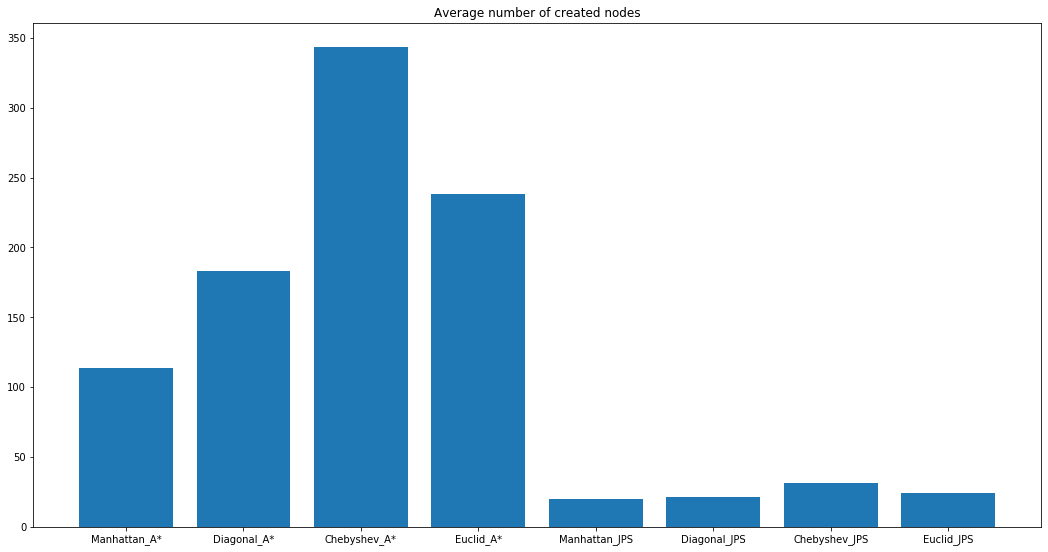

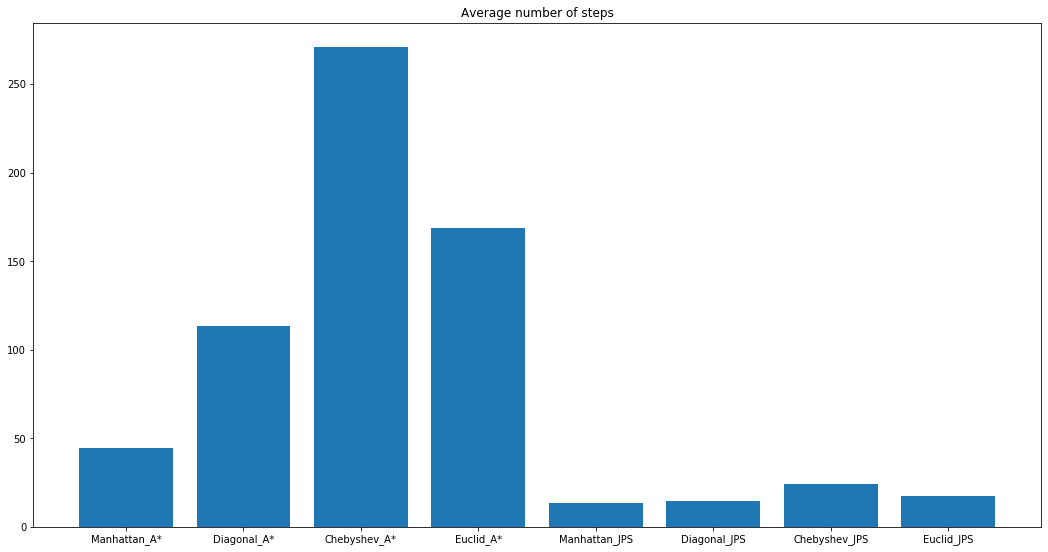

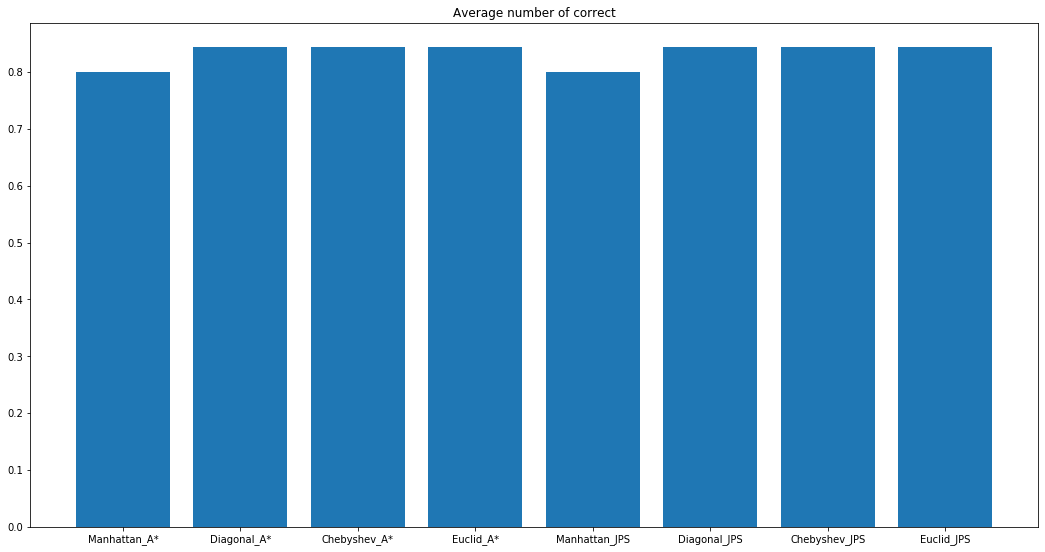

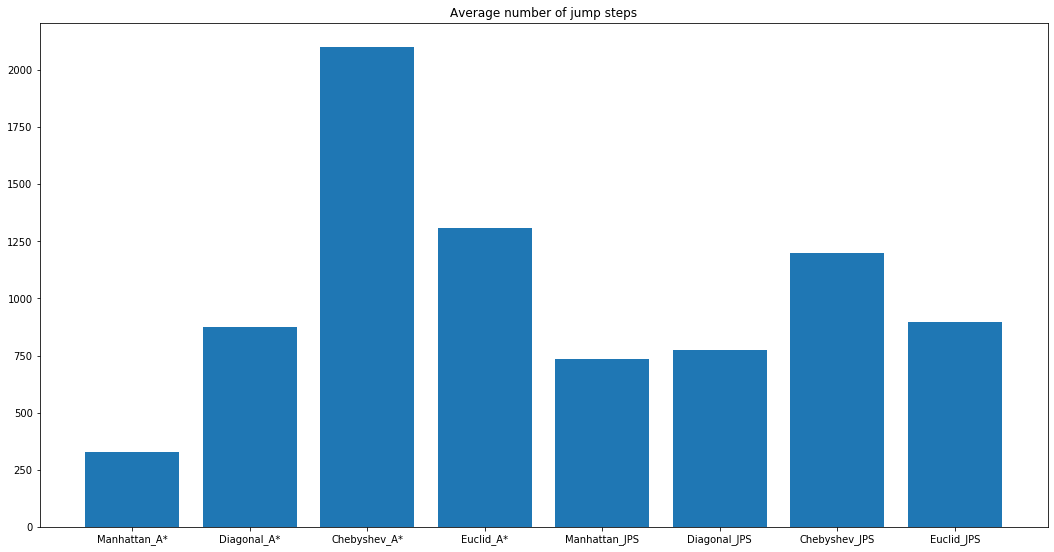

In [47]:
createdNodes = []
stepsNumber = []
correct = []
jumpSteps = []
results = [manh_mass, diag_mass, cheb_mass, eucl_mass,
           manh_mass_jump, diag_mass_jump, cheb_mass_jump, eucl_mass_jump]
for res in results:
    createdNodes.append(sum([x[0] + x[1] for x in res.values()]) / len(res.values()))
    stepsNumber.append(sum([x[1] for x in res.values()]) / len(res.values()))
    correct.append(sum([int(x[2]) for x in res.values()]) / len(res.values()))
    jumpSteps.append(sum([x[-1] for x in res.values()]) / len(res.values()))
# show results
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of created nodes')
alg = ['Manhattan_A*', 'Diagonal_A*', 'Chebyshev_A*', 'Euclid_A*',
       'Manhattan_JPS', 'Diagonal_JPS', 'Chebyshev_JPS', 'Euclid_JPS']
ax.bar(alg, createdNodes)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of steps')
ax.bar(alg, stepsNumber)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of correct')
ax.bar(alg, correct)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of jump steps')
ax.bar(alg, jumpSteps)
plt.show()

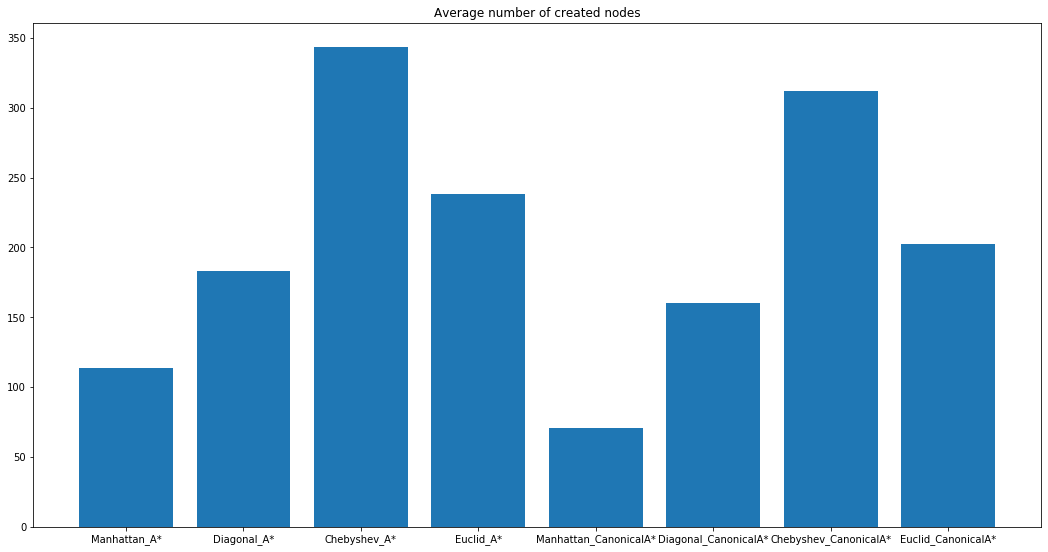

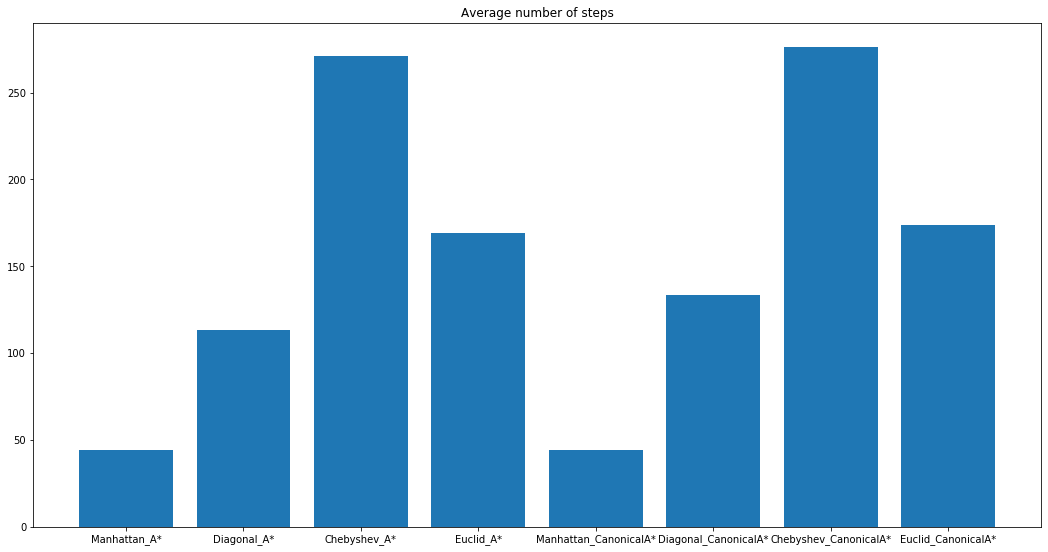

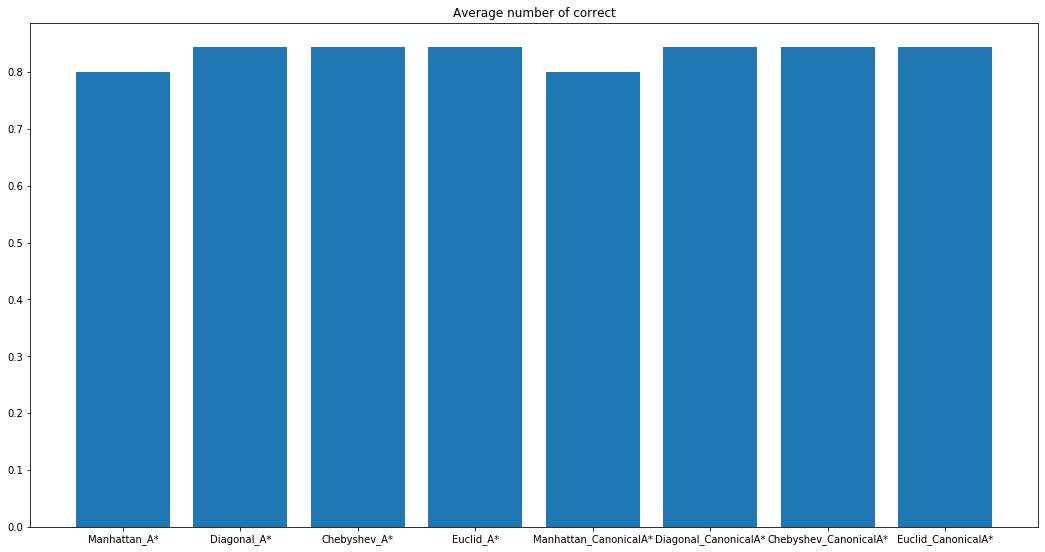

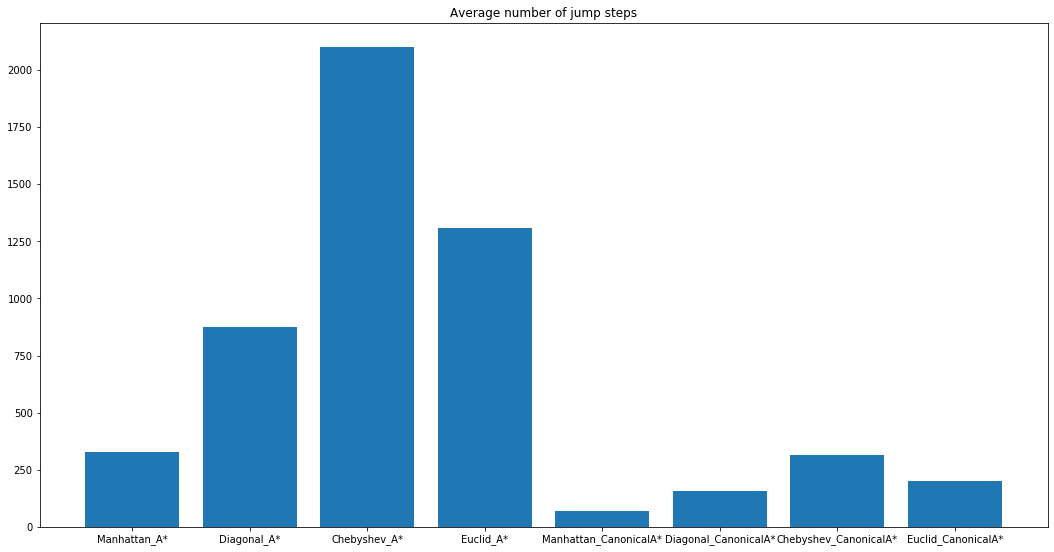

In [48]:
createdNodes = []
stepsNumber = []
correct = []
jumpSteps = []
results = [manh_mass, diag_mass, cheb_mass, eucl_mass,
           manh_mass_can, diag_mass_can, cheb_mass_can, eucl_mass_can]
for res in results:
    createdNodes.append(sum([x[0] + x[1] for x in res.values()]) / len(res.values()))
    stepsNumber.append(sum([x[1] for x in res.values()]) / len(res.values()))
    correct.append(sum([int(x[2]) for x in res.values()]) / len(res.values()))
    jumpSteps.append(sum([x[-1] for x in res.values()]) / len(res.values()))
# show results
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of created nodes')
alg = ['Manhattan_A*', 'Diagonal_A*', 'Chebyshev_A*', 'Euclid_A*',
       'Manhattan_CanonicalA*', 'Diagonal_CanonicalA*', 'Chebyshev_CanonicalA*', 'Euclid_CanonicalA*']
ax.bar(alg, createdNodes)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of steps')
ax.bar(alg, stepsNumber)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of correct')
ax.bar(alg, correct)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of jump steps')
ax.bar(alg, jumpSteps)
plt.show()

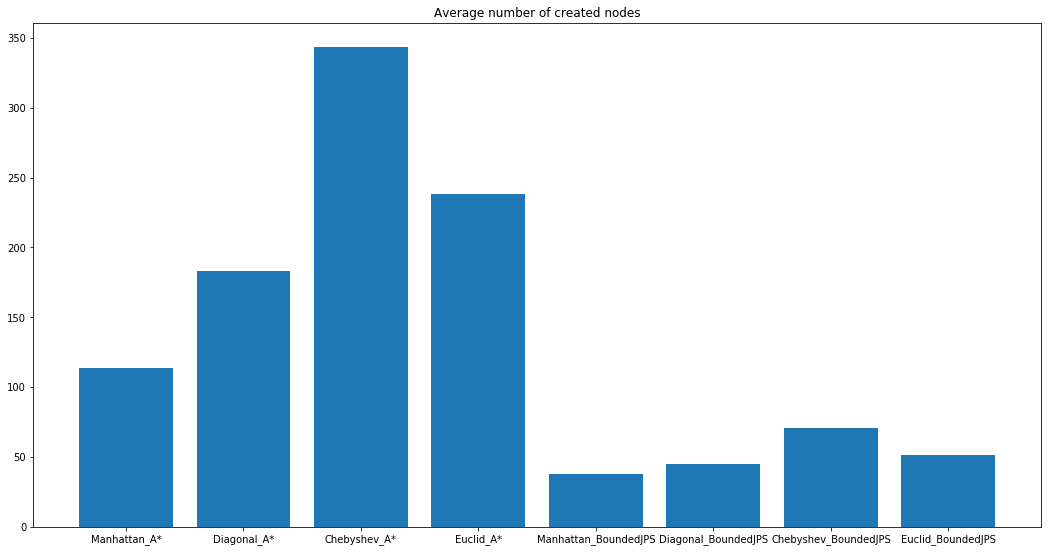

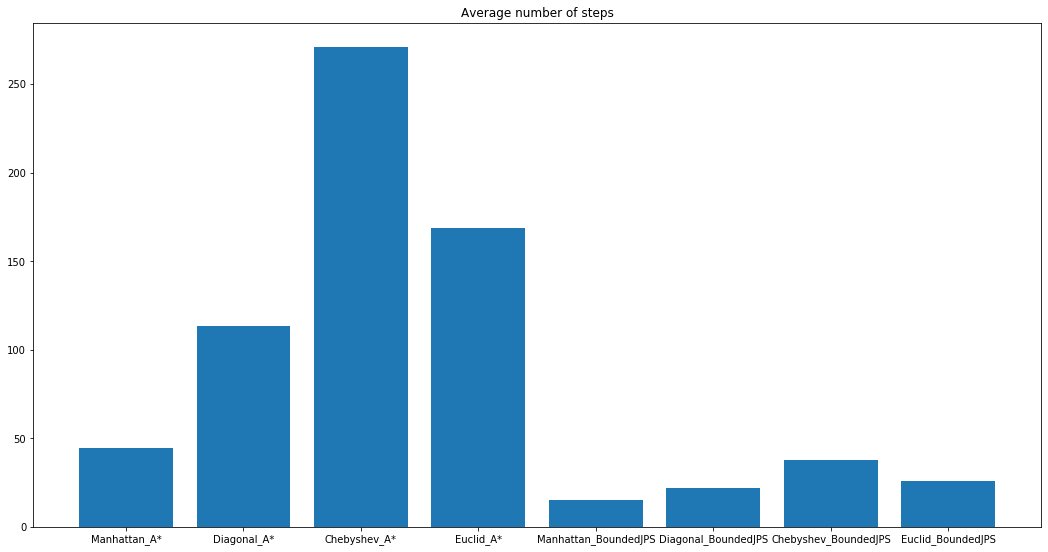

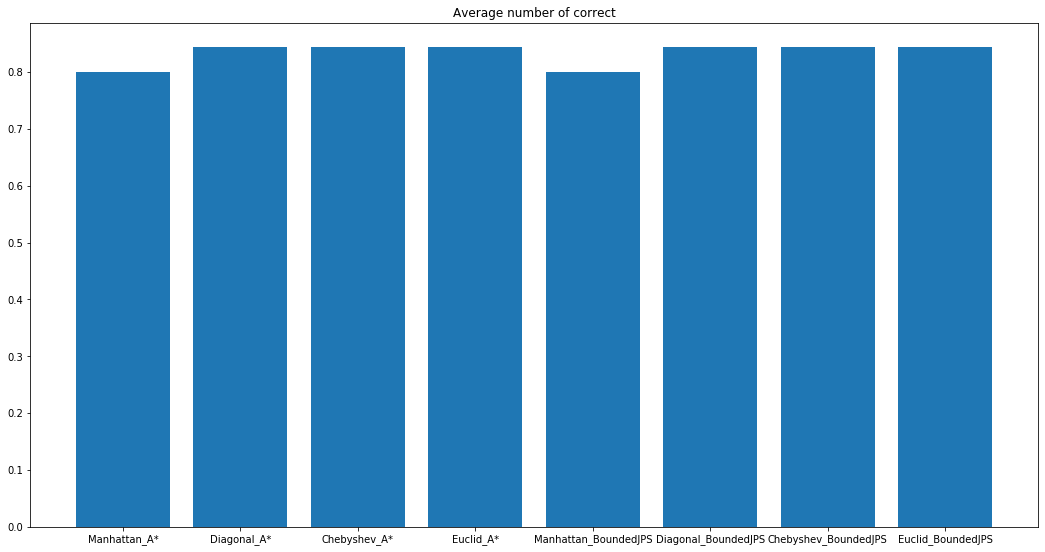

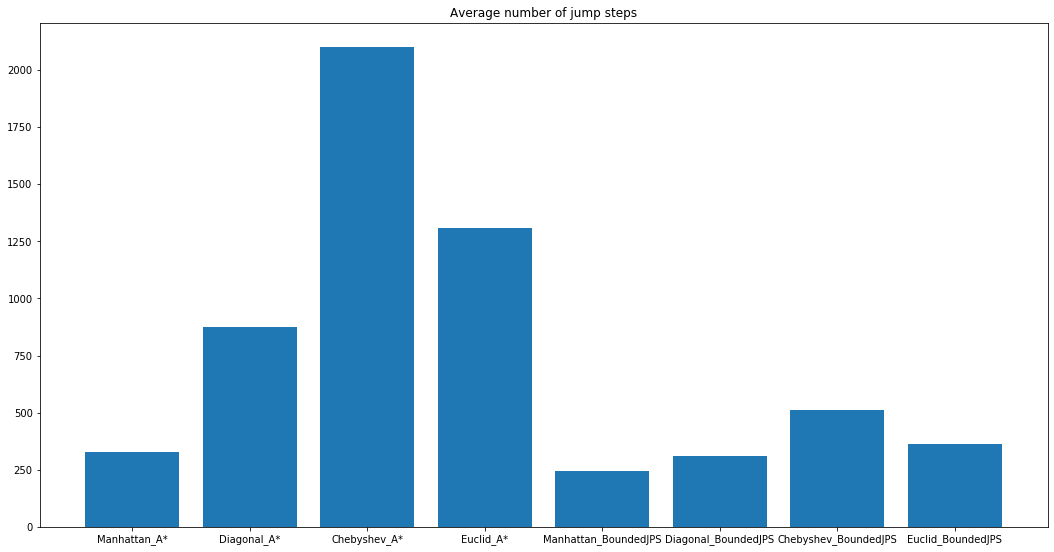

In [49]:
createdNodes = []
stepsNumber = []
correct = []
jumpSteps = []
results = [manh_mass, diag_mass, cheb_mass, eucl_mass,
           manh_mass_bound, diag_mass_bound, cheb_mass_bound, eucl_mass_bound]
for res in results:
    createdNodes.append(sum([x[0] + x[1] for x in res.values()]) / len(res.values()))
    stepsNumber.append(sum([x[1] for x in res.values()]) / len(res.values()))
    correct.append(sum([int(x[2]) for x in res.values()]) / len(res.values()))
    jumpSteps.append(sum([x[-1] for x in res.values()]) / len(res.values()))
# show results
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of created nodes')
alg = ['Manhattan_A*', 'Diagonal_A*', 'Chebyshev_A*', 'Euclid_A*',
       'Manhattan_BoundedJPS', 'Diagonal_BoundedJPS', 'Chebyshev_BoundedJPS', 'Euclid_BoundedJPS']
ax.bar(alg, createdNodes)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of steps')
ax.bar(alg, stepsNumber)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of correct')
ax.bar(alg, correct)
plt.show()
fig = plt.figure(figsize=(14, 7))
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of jump steps')
ax.bar(alg, jumpSteps)
plt.show()

### Summary results

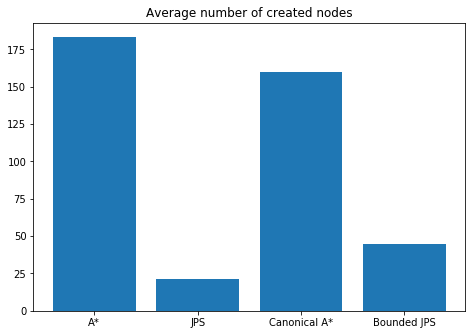

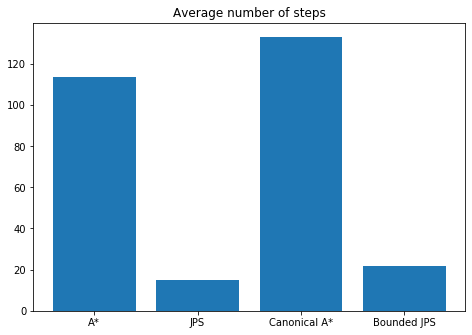

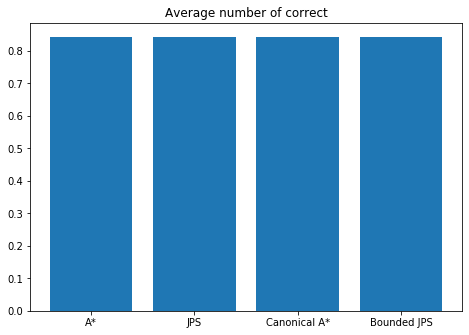

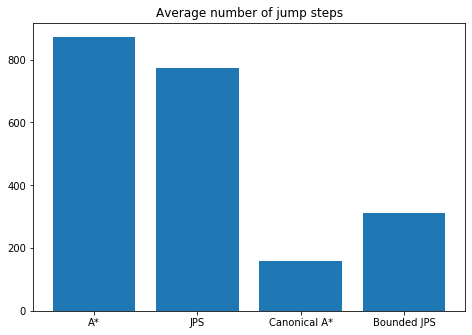

In [50]:
createdNodes = []
stepsNumber = []
correct = []
jumpSteps = []
results = [diag_mass, diag_mass_jump, diag_mass_can, diag_mass_bound]
for res in results:
    createdNodes.append(sum([x[0] + x[1] for x in res.values()]) / len(res.values()))
    stepsNumber.append(sum([x[1] for x in res.values()]) / len(res.values()))
    correct.append(sum([int(x[2]) for x in res.values()]) / len(res.values()))
    jumpSteps.append(sum([x[-1] for x in res.values()]) / len(res.values()))
# show results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of created nodes')
alg = ['A*', 'JPS', 'Canonical A*', 'Bounded JPS']
ax.bar(alg, createdNodes)
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of steps')
ax.bar(alg, stepsNumber)
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of correct')
ax.bar(alg, correct)
plt.show()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title('Average number of jump steps')
ax.bar(alg, jumpSteps)
plt.show()

### Результаты
Эксперименты проводились на трех картах - arena.map, den001d.map, Berlin_0_256.map. В качестве заданий для каждой карты брались первые 150 заданий из соответствующего файла.

Были реализованы и сравнены 4 алгоритма - A*, JPS, Canonical A*, Bounded JPS. Для всех алгоритмов можно заметить, что они находят оптимальный путь не во всех случаях - это связано с особенностями реализации карт. В исходных картах оптимальный путь расчитан с учетом запрета срезания углов через непроходимые клетки, но в данных алгоритмах такое срезание является частью алгоритма. Поэтому был изменен формат карты, и, соответственно, и оптимальные пути.

По результатам можно увидеть, что все три алгоритма - JPS, Canonical A*, Bounded JPS - работают эффективнее, чем A*. Наилучший результат показывает JPS, также хороший результат показывает Bounded JPS - в данном случае это происходит из-за того, что Bounded JPS лучше работает на больших открытых пространствах. Canonical A* показывает результаты, сравнимые с A*, но при этом требует гораздо меньшее число jump steps - в данной работе так обозначено количество рассматриваемых в A* соседей текущего узла (для A* и Canonical A*, для JPS & Bounded JPS - это число рассматриваемых клеток при нахождении jump points).